In [2]:
# import required libraries
import pandas as pd
import yfinance as yf
import numpy as np
import math
import ccxt
from ta import momentum, trend, volatility
from pymoo.algorithms.moo.age import AGEMOEA
from pymoo.core.problem import Problem
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
import matplotlib.pyplot as plt

C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pymoo\algorithms\moo\age.py:212: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(fastmath=True)
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pymoo\algorithms\moo\age.py:222: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/de

In [38]:
def fetch_data(timeframe):
    exchange = ccxt.kraken()
    start_timestamp = 1451606400000  # timestamp for 1 Jan 2016
    end_timestamp = 1651392000000  # timestamp for 1 May 2023
    interval_seconds = exchange.parse_timeframe(timeframe)  # convert timeframe to seconds
    limit = int((end_timestamp - start_timestamp) / interval_seconds) + 1
    ohlcv = exchange.fetch_ohlcv('BTC/AUD', timeframe=timeframe, since=start_timestamp, limit=limit)
    return ohlcv

# get stock prices
#ohlcv = yf.download('BTC', start='2020-01-01', threads= False)
ohlcv = fetch_data('1d')

df = pd.DataFrame(ohlcv)
df.columns = ['time', 'open', 'high', 'low', 'close', 'volume']
#df['time'] = pd.to_datetime(df['time'], unit='ms')
df

,time,open,high,low,close,volume
0,1621468800000,48240.4,55139.8,45531.7,52914.0,50.023423
1,1621555200000,53207.8,54675.8,43545.6,48438.4,72.883894
2,1621641600000,48449.2,50262.5,45839.1,48483.6,33.799277
3,1621728000000,48482.4,49509.9,40521.3,45347.2,61.982295
4,1621814400000,45405.2,51636.1,44408.0,50154.2,31.160977
...,...,...,...,...,...,...
715,1683244800000,43106.5,43974.6,43038.0,43835.6,5.565951
716,1683331200000,43841.9,44261.6,42285.7,43001.6,2.830672
717,1683417600000,42982.9,43329.7,42272.3,42341.6,2.902877
718,1683504000000,42314.3,42574.4,40390.8,40918.8,21.387002


Short return: -0.045821211155266606, current total: 0.9522704312670439
Short return: -0.04633254184702995, current total: 0.906333023017353
Short return: -0.06750679764683132, current total: 0.8434590842658158
Long return: -0.07017055499121683, current total: 0.7827045460260791
Short return: 0.07096531489337221, current total: 0.8365729217620871
Short return: 0.06455010717060783, current total: 0.8887926459308226
Long return: 0.06392309587367562, current total: 0.9437158094015795
Short return: 0.10338044284879189, current total: 1.0391950125655192
Short return: 0.10506598610191853, current total: 1.1460823031902851
Long return: -0.03742697934378203, current total: 1.1009815286935032
Long return: 0.08397568978276682, current total: 1.191050337579618
Short return: 0.06630167687188293, current total: 1.267478934255569
Long return: 0.06629620268952907, current total: 1.348804958636513
Long return: -0.11282122948401418, current total: 1.1942378626192687
Short return: -0.05239438763931026, c

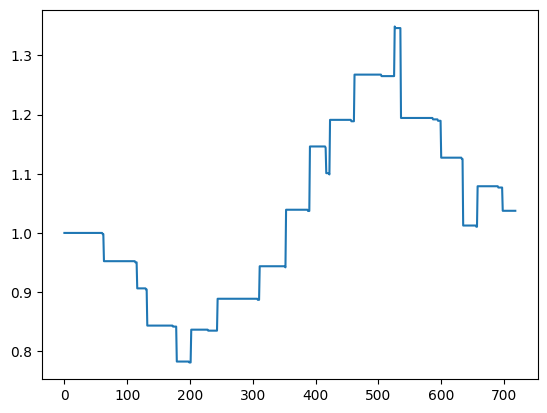

In [39]:

# parameter setup
length = 20
mult = 2
length_KC = 20
mult_KC = 1.5

#Calculate percent change
df['change'] = df['close'].pct_change(1)

# calculate BB
m_avg = trend.sma_indicator(df['close'],window=length)
#m_avg = df['close'].rolling(window=length).mean()
m_std = df['close'].rolling(window=length).std(ddof=0)
df['upper_BB'] = m_avg + mult * m_std
df['lower_BB'] = m_avg - mult * m_std

# calculate true range
df['tr0'] = abs(df["high"] - df["low"])
df['tr1'] = abs(df["high"] - df["close"].shift())
df['tr2'] = abs(df["low"] - df["close"].shift())
df['tr'] = df[['tr0', 'tr1', 'tr2']].max(axis=1)

# calculate Keltner Channels
range_ma = df['tr'].rolling(window=length_KC).mean()
df['upper_KC'] = m_avg + range_ma * mult_KC
df['lower_KC'] = m_avg - range_ma * mult_KC

# calculate bar value
highest = df['high'].rolling(window = length_KC).max()
lowest = df['low'].rolling(window = length_KC).min()
m1 = (highest + lowest)/2
df['value'] = (df['close'] - (m1 + m_avg)/2)
fit_y = np.array(range(0,length_KC))
df['value'] = df['value'].rolling(window = length_KC).apply(lambda x: 
                          np.polyfit(fit_y, x, 1)[0] * (length_KC-1) + 
                          np.polyfit(fit_y, x, 1)[1], raw=True)

# check for 'squeeze'
df['squeeze_on'] = (df['lower_BB'] > df['lower_KC']) & (df['upper_BB'] < df['upper_KC'])
df['squeeze_off'] = (df['lower_BB'] < df['lower_KC']) & (df['upper_BB'] > df['upper_KC'])

# buying window for long position:
# 1. black cross becomes gray (the squeeze is released)
long_cond1 = (df['squeeze_off'].shift(2)  == False) & (df['squeeze_off'].shift(1)  == True) 
# 2. bar value is positive => the bar is light green k
long_cond2 = df['value'].shift(1)  > 0
df['enter_long'] = long_cond1 & long_cond2

# buying window for short position:
# 1. black cross becomes gray (the squeeze is released)
short_cond1 = (df['squeeze_off'].shift(2) == False) & (df['squeeze_off'].shift(1)  == True) 
# 2. bar value is negative => the bar is light red 
short_cond2 = df['value'].shift(1)  < 0
df['enter_short'] = short_cond1 & short_cond2

# Set stop-loss and take-profit levels
stop_loss_pct = 0.03
take_profit_pct = 0.06

# Calculate stop-loss and take-profit prices for long positions
in_long_position = False
in_short_position = False
cumulative_return = 1.0
current_trade_return = 1.0
START_BALANCE = 100
FEE = 0.002
all_trades = []
cum_returns = []

for i in range(1, len(df)):
    # Long trades
    if df['enter_long'][i] == True and not in_short_position:
        in_long_position = True
        cumulative_return *= (1 - FEE)
        current_trade_return = 1.0
    elif in_long_position:
        current_trade_return *= (1 + df['change'][i])
        if (current_trade_return >= (1+take_profit_pct) or current_trade_return <= (1-stop_loss_pct)):
            in_long_position = False
            cumulative_return *= current_trade_return
            print(f'Long return: {current_trade_return - 1}, current total: {cumulative_return}')
            all_trades.append(current_trade_return)
            current_trade_return = 1.0
            
    # Short trades
    if df['enter_short'][i] == True and not in_long_position:
        in_short_position = True
        cumulative_return *= (1 - FEE)
        current_trade_return = 1.0
    elif in_short_position:
        current_trade_return *= (1 - df['change'][i])
        if (current_trade_return >= (1+take_profit_pct) or current_trade_return <= (1-stop_loss_pct)):
            in_short_position = False
            cumulative_return *= current_trade_return
            print(f'Short return: {current_trade_return - 1}, current total: {cumulative_return}')
            all_trades.append(current_trade_return-1)
            current_trade_return = 1.0
    cum_returns.append(cumulative_return)
print(f"Final Balance: {round(START_BALANCE*(cumulative_return),2)}'\n'Net Profit: {round((cumulative_return-1)*100,2)}%'\n'Risk: {round(np.std(all_trades)*100,2)}%")
plt.plot(cum_returns)


In [55]:
#Constants
START_BALANCE = 100
FEE = 0.02

#Fetch data from Kraken Exchange
def fetch_data(timeframe):
    exchange = ccxt.kraken()
    start_timestamp = 1451606400000  # timestamp for 1 Jan 2016
    end_timestamp = 1651392000000  # timestamp for 1 May 2023
    interval_seconds = exchange.parse_timeframe(timeframe) * 60  # convert timeframe to seconds
    limit = int((end_timestamp - start_timestamp) / interval_seconds) + 1
    ohlcv = exchange.fetch_ohlcv('BTC/AUD', timeframe=timeframe, since=start_timestamp, limit=limit)
    return ohlcv

ohlcv = fetch_data('1d')
df = pd.DataFrame(ohlcv)
df.columns = ['time', 'open', 'high', 'low', 'close', 'volume']
df['time'] = pd.to_datetime(df['time'], unit='ms')
df['returns'] = df['close'].pct_change()

In [95]:
def strategy(df, length = 20,mult = 2,length_KC = 20, mult_KC = 1.5, stop_loss_pct = 0.03, take_profit_pct=0.06):

    length = int(length)
    length_KC = int(length_KC)

    #Calculate percent change
    epsilon = 1e-8
    df['change'] = df['close'].pct_change(1).fillna(epsilon)

    # calculate BB
    m_avg = trend.sma_indicator(df['close'],window=length)
    #m_avg = df['close'].rolling(window=length).mean()
    m_std = df['close'].rolling(window=length).std(ddof=0)
    df['upper_BB'] = m_avg + mult * m_std
    df['lower_BB'] = m_avg - mult * m_std

    # calculate true range
    df['tr0'] = abs(df["high"] - df["low"])
    df['tr1'] = abs(df["high"] - df["close"].shift())
    df['tr2'] = abs(df["low"] - df["close"].shift())
    df['tr'] = df[['tr0', 'tr1', 'tr2']].max(axis=1)

    # calculate Keltner Channels
    range_ma = df['tr'].rolling(window=length_KC).mean()
    df['upper_KC'] = m_avg + range_ma * mult_KC
    df['lower_KC'] = m_avg - range_ma * mult_KC

    # calculate bar value
    highest = df['high'].rolling(window = length_KC).max()
    lowest = df['low'].rolling(window = length_KC).min()
    m1 = (highest + lowest)/2
    df['value'] = (df['close'] - (m1 + m_avg)/2)
    fit_y = np.array(range(0,length_KC))
    df['value'] = df['value'].rolling(window = length_KC).apply(lambda x: 
                              np.polyfit(fit_y, x, 1)[0] * (length_KC-1) + 
                              np.polyfit(fit_y, x, 1)[1], raw=True)

    # check for 'squeeze'
    df['squeeze_on'] = (df['lower_BB'] > df['lower_KC']) & (df['upper_BB'] < df['upper_KC'])
    df['squeeze_off'] = (df['lower_BB'] < df['lower_KC']) & (df['upper_BB'] > df['upper_KC'])

    #Check if already in trading position
    

    # buying window for long position:
    # 1. black cross becomes gray (the squeeze is released)
    long_cond1 = (df['squeeze_off'].shift(2)  == False) & (df['squeeze_off'].shift(1)  == True) 
    # 2. bar value is positive => the bar is light green k
    long_cond2 = df['value'].shift(1)  > 0
    df['enter_long'] = long_cond1 & long_cond2

    # buying window for short position:
    # 1. black cross becomes gray (the squeeze is released)
    short_cond1 = (df['squeeze_off'].shift(2) == False) & (df['squeeze_off'].shift(1)  == True) 
    # 2. bar value is negative => the bar is light red 
    short_cond2 = df['value'].shift(1)  < 0
    df['enter_short'] = short_cond1 & short_cond2

    # Calculate stop-loss and take-profit prices for long positions
    in_long_position = False
    in_short_position = False
    cumulative_return = 1.0
    current_trade_return = 1.0
    all_trades = []

    for i in range(1, len(df)):
        # Long trades
        if df['enter_long'][i] == True and not in_short_position and not in_long_position:
            #print("Entered long - ", in_long_position)
            in_long_position = True
            cumulative_return *= (1 - FEE)
            current_trade_return = 1.0
            
        elif in_long_position:
            current_trade_return *= (1 + df['change'][i])
            if (current_trade_return >= (1+take_profit_pct) or current_trade_return <= (1-stop_loss_pct)):
                in_long_position = False
                cumulative_return *= current_trade_return
                #print(f'Long return: {current_trade_return - 1}, current total: {cumulative_return}')
                all_trades.append(current_trade_return)
                current_trade_return = 1.0

        # Short trades
        if df['enter_short'][i] == True and not in_long_position and not in_short_position:
            in_short_position = True
            cumulative_return *= (1 - FEE)
            current_trade_return = 1.0
            #print("Entered short")
        elif in_short_position:
            current_trade_return *= (1 - df['change'][i])
            if (current_trade_return >= (1+take_profit_pct) or current_trade_return <= (1-stop_loss_pct)):
                in_short_position = False
                cumulative_return *= current_trade_return
                #print(f'Short return: {current_trade_return - 1}, current total: {cumulative_return}')
                all_trades.append(current_trade_return-1)
                current_trade_return = 1.0
        #print(cumulative_return)
    total_risk = np.std(all_trades)
    print(f"Total Return: {round(START_BALANCE*(cumulative_return),2)}'\n'Net Profit: {round((cumulative_return-1)*100,2)}%'\n'Risk: {round(np.std(all_trades)*100,2)}%")
    return (cumulative_return-1), total_risk

ret, strisk = strategy(df, 9, 1.2515944085963733, 26, 2.099874852943471, 0.08361683760304216, 0.07991898158714686)
print(ret, strisk)
#22, 1.6974089415550258, 8, 2.9543830658310735, 0.05647984310804855, 0.1752016962048809

Total Return: 167.52'
'Net Profit: 67.52%'
'Risk: 52.6%
0.6752488978187834 0.5260342290464448


In [96]:
# Generic Genetic Algorithm

import random
from deap import base, creator, tools

def fitness_function(hyperparameters):
    length, mult, length_KC, mult_KC, stop_loss_pct, take_profit_pct = hyperparameters
    ret, strisk = strategy(df, length, mult, length_KC, mult_KC, stop_loss_pct, take_profit_pct)

    # Objective 1: Maximize return
    # Objective 2: Minimize risk (1/strisk)
    return ret, 1/strisk

# Create types
creator.create("FitnessMulti", base.Fitness, weights=(1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)

# Initialize the required components for the genetic algorithm
toolbox = base.Toolbox()
toolbox.register("attr_length", random.randint, 5, 30)
toolbox.register("attr_mult", random.uniform, 1, 3)
toolbox.register("attr_length_KC", random.randint, 5, 30)
toolbox.register("attr_mult_KC", random.uniform, 1, 3)
toolbox.register("attr_stop_loss_pct", random.uniform, 0.01, 0.1)
toolbox.register("attr_take_profit_pct", random.uniform, 0.01, 0.1)

toolbox.register("individual", tools.initCycle, creator.Individual, 
                 (toolbox.attr_length, toolbox.attr_mult, toolbox.attr_length_KC, toolbox.attr_mult_KC, 
                  toolbox.attr_stop_loss_pct, toolbox.attr_take_profit_pct), n=1)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxUniform, indpb=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.1)
toolbox.register("select", tools.selNSGA2)
toolbox.register("evaluate", fitness_function)

# Parameters
population_size = 100
generations = 10
crossover_probability = 0.8
mutation_probability = 0.1

# Create the initial population
population = toolbox.population(n=population_size)

# Evaluate the fitness of each individual in the population
fitnesses = list(map(toolbox.evaluate, population))
for ind, fit in zip(population, fitnesses):
    ind.fitness.values = fit

# Assign crowding distance to each individual in the population
tools.emo.assignCrowdingDist(population)

# Begin the evolution
for gen in range(generations):
    print('Generation: ', gen)
    offspring = tools.selTournamentDCD(population, len(population))
    offspring = [toolbox.clone(ind) for ind in offspring]

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < crossover_probability:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < mutation_probability:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the fitness of each individual in the new generation
    fitnesses = list(map(toolbox.evaluate, offspring))
    for ind, fit in zip(offspring, fitnesses):
        ind.fitness.values = fit

    # Replace the old population by the offspring
    population[:] = offspring
    population = toolbox.select(population, len(population))

# Get the best individual from the final population
best_ind = tools.selBest(population, 1)[0]
print("Best individual is %s with fitness: %s" % (best_ind, best_ind.fitness.values))


C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Total Return: 125.04'
'Net Profit: 25.04%'
'Risk: 48.31%
Total Return: 70.76'
'Net Profit: -29.24%'
'Risk: 46.97%
Total Return: 68.54'
'Net Profit: -31.46%'
'Risk: 49.51%
Total Return: 89.69'
'Net Profit: -10.31%'
'Risk: 47.09%
Total Return: 92.43'
'Net Profit: -7.57%'
'Risk: 50.64%
Total Return: 59.76'
'Net Profit: -40.24%'
'Risk: 50.35%
Total Return: 55.01'
'Net Profit: -44.99%'
'Risk: 50.11%
Total Return: 48.89'
'Net Profit: -51.11%'
'Risk: 46.33%
Total Return: 56.82'
'Net Profit: -43.18%'
'Risk: 51.58%
Total Return: 89.23'
'Net Profit: -10.77%'
'Risk: 42.88%
Total Return: 74.72'
'Net Profit: -25.28%'
'Risk: 48.29%
Total Return: 26.98'
'Net Profit: -73.02%'
'Risk: 49.14%
Total Return: 24.6'
'Net Profit: -75.4%'
'Risk: 47.33%
Total Return: 74.03'
'Net Profit: -25.97%'
'Risk: 48.12%
Total Return: 65.39'
'Net Profit: -34.61%'
'Risk: 48.91%
Total Return: 106.38'
'Net Profit: 6.38%'
'Risk: 0.69%
Total Return: 57.31'
'Net Profit: -42.69%'
'Risk: 51.34%
Total Return: 55.46'
'Net Profit: -4

C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 109.78'
'Net Profit: 9.78%'
'Risk: 51.94%
Total Return: 65.4'
'Net Profit: -34.6%'
'Risk: 50.8%
Total Return: 95.86'
'Net Profit: -4.14%'
'Risk: 47.15%
Total Return: 101.61'
'Net Profit: 1.61%'
'Risk: 52.56%
Total Return: 48.81'
'Net Profit: -51.19%'
'Risk: 41.63%
Total Return: 85.33'
'Net Profit: -14.67%'
'Risk: 0.0%
Total Return: 88.97'
'Net Profit: -11.03%'
'Risk: 43.31%
Total Return: 73.81'
'Net Profit: -26.19%'
'Risk: 49.95%
Total Return: 49.96'
'Net Profit: -50.04%'
'Risk: 49.52%
Total Return: 100.2'
'Net Profit: 0.2%'
'Risk: 51.65%


C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 33.89'
'Net Profit: -66.11%'
'Risk: 48.56%
Total Return: 111.65'
'Net Profit: 11.65%'
'Risk: 48.3%
Total Return: 38.02'
'Net Profit: -61.98%'
'Risk: 51.67%
Total Return: 56.39'
'Net Profit: -43.61%'
'Risk: 49.6%
Total Return: 78.05'
'Net Profit: -21.95%'
'Risk: 46.97%
Total Return: 34.76'
'Net Profit: -65.24%'
'Risk: 47.23%
Total Return: 67.3'
'Net Profit: -32.7%'
'Risk: 45.23%
Total Return: 78.52'
'Net Profit: -21.48%'
'Risk: 51.36%
Total Return: 88.9'
'Net Profit: -11.1%'
'Risk: 9.05%
Total Return: 57.18'
'Net Profit: -42.82%'
'Risk: 49.3%
Total Return: 131.29'
'Net Profit: 31.29%'
'Risk: 50.4%
Total Return: 67.24'
'Net Profit: -32.76%'
'Risk: 47.57%
Total Return: 47.34'
'Net Profit: -52.66%'
'Risk: 50.82%
Total Return: 50.68'
'Net Profit: -49.32%'
'Risk: 50.34%
Total Return: 45.77'
'Net Profit: -54.23%'
'Risk: 47.94%
Total Return: 103.45'
'Net Profit: 3.45%'
'Risk: 54.27%
Total Return: 35.43'
'Net Profit: -64.57%'
'Risk: 50.63%
Total Return: 106.73'
'Net Profit: 6.73%'

C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 69.72'
'Net Profit: -30.28%'
'Risk: 46.01%
Total Return: 49.6'
'Net Profit: -50.4%'
'Risk: 50.89%
Total Return: 140.37'
'Net Profit: 40.37%'
'Risk: 44.34%
Total Return: 79.79'
'Net Profit: -20.21%'
'Risk: 49.45%
Total Return: 84.51'
'Net Profit: -15.49%'
'Risk: 48.88%
Total Return: 39.42'
'Net Profit: -60.58%'
'Risk: 49.27%
Total Return: 100.0'
'Net Profit: 0.0%'
'Risk: nan%
Total Return: 77.43'
'Net Profit: -22.57%'
'Risk: 51.47%
Total Return: 77.76'
'Net Profit: -22.24%'
'Risk: 49.31%


C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Total Return: 112.88'
'Net Profit: 12.88%'
'Risk: 46.86%
Total Return: 108.78'
'Net Profit: 8.78%'
'Risk: 51.73%
Total Return: 100.0'
'Net Profit: 0.0%'
'Risk: nan%
Total Return: 94.73'
'Net Profit: -5.27%'
'Risk: 0.0%


C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 42.79'
'Net Profit: -57.21%'
'Risk: 50.11%
Total Return: 105.19'
'Net Profit: 5.19%'
'Risk: 52.89%
Total Return: 63.26'
'Net Profit: -36.74%'
'Risk: 51.61%
Total Return: 33.42'
'Net Profit: -66.58%'
'Risk: 51.05%
Total Return: 94.92'
'Net Profit: -5.08%'
'Risk: 57.94%
Total Return: 62.39'
'Net Profit: -37.61%'
'Risk: 47.88%
Total Return: 108.72'
'Net Profit: 8.72%'
'Risk: 54.58%
Total Return: 37.98'
'Net Profit: -62.02%'
'Risk: 49.39%
Total Return: 79.58'
'Net Profit: -20.42%'
'Risk: 49.73%
Total Return: 106.87'
'Net Profit: 6.87%'
'Risk: 49.47%
Total Return: 43.63'
'Net Profit: -56.37%'
'Risk: 49.4%
Total Return: 73.91'
'Net Profit: -26.09%'
'Risk: 49.22%
Total Return: 114.78'
'Net Profit: 14.78%'
'Risk: 46.69%
Total Return: 80.67'
'Net Profit: -19.33%'
'Risk: 45.04%
Total Return: 80.3'
'Net Profit: -19.7%'
'Risk: 53.32%
Total Return: 86.52'
'Net Profit: -13.48%'
'Risk: 50.42%
Total Return: 99.7'
'Net Profit: -0.3%'
'Risk: 55.05%
Total Return: 51.19'
'Net Profit: -48.81%

C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\deap\tools\emo.py:139: RuntimeWarning: invalid value encountered in double_scalars
  distances[cur[1]] += (next[0][i] - prev[0][i]) / norm


Total Return: 83.88'
'Net Profit: -16.12%'
'Risk: 46.36%
Total Return: 43.93'
'Net Profit: -56.07%'
'Risk: 48.51%
Total Return: 49.6'
'Net Profit: -50.4%'
'Risk: 50.89%
Total Return: 80.67'
'Net Profit: -19.33%'
'Risk: 45.04%
Total Return: 61.73'
'Net Profit: -38.27%'
'Risk: 48.54%
Total Return: 46.69'
'Net Profit: -53.31%'
'Risk: 53.45%
Total Return: 78.05'
'Net Profit: -21.95%'
'Risk: 46.97%
Total Return: 77.43'
'Net Profit: -22.57%'
'Risk: 51.47%
Total Return: 51.67'
'Net Profit: -48.33%'
'Risk: 48.66%
Total Return: 71.96'
'Net Profit: -28.04%'
'Risk: 49.88%
Total Return: 77.7'
'Net Profit: -22.3%'
'Risk: 49.01%
Total Return: 40.37'
'Net Profit: -59.63%'
'Risk: 45.9%
Total Return: 22.47'
'Net Profit: -77.53%'
'Risk: 50.72%
Total Return: 89.54'
'Net Profit: -10.46%'
'Risk: 52.03%
Total Return: 74.35'
'Net Profit: -25.65%'
'Risk: 49.89%
Total Return: 116.51'
'Net Profit: 16.51%'
'Risk: 49.96%
Total Return: 66.8'
'Net Profit: -33.2%'
'Risk: 45.28%
Total Return: 107.94'
'Net Profit: 7.9

C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 61.15'
'Net Profit: -38.85%'
'Risk: 46.84%
Total Return: 108.54'
'Net Profit: 8.54%'
'Risk: 43.3%
Total Return: 93.15'
'Net Profit: -6.85%'
'Risk: 49.88%
Total Return: 83.38'
'Net Profit: -16.62%'
'Risk: 53.53%
Total Return: 100.0'
'Net Profit: 0.0%'
'Risk: nan%


C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Total Return: 100.43'
'Net Profit: 0.43%'
'Risk: 49.77%
Total Return: 92.43'
'Net Profit: -7.57%'
'Risk: 50.64%
Total Return: 87.98'
'Net Profit: -12.02%'
'Risk: 49.89%
Total Return: 101.5'
'Net Profit: 1.5%'
'Risk: 57.2%
Total Return: 88.0'
'Net Profit: -12.0%'
'Risk: 51.26%
Total Return: 123.07'
'Net Profit: 23.07%'
'Risk: 54.32%
Total Return: 85.38'
'Net Profit: -14.62%'
'Risk: 51.74%
Total Return: 118.01'
'Net Profit: 18.01%'
'Risk: 51.58%
Total Return: 106.73'
'Net Profit: 6.73%'
'Risk: 0.0%


C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 66.78'
'Net Profit: -33.22%'
'Risk: 43.47%
Total Return: 108.78'
'Net Profit: 8.78%'
'Risk: 51.73%
Total Return: 93.6'
'Net Profit: -6.4%'
'Risk: 50.99%
Total Return: 72.42'
'Net Profit: -27.58%'
'Risk: 49.12%
Total Return: 113.57'
'Net Profit: 13.57%'
'Risk: 49.42%
Total Return: 96.33'
'Net Profit: -3.67%'
'Risk: 52.86%
Total Return: 117.23'
'Net Profit: 17.23%'
'Risk: 46.26%
Total Return: 83.42'
'Net Profit: -16.58%'
'Risk: 50.06%
Total Return: 64.03'
'Net Profit: -35.97%'
'Risk: 48.45%
Total Return: 77.9'
'Net Profit: -22.1%'
'Risk: 50.91%
Total Return: 108.1'
'Net Profit: 8.1%'
'Risk: 52.69%
Total Return: 55.01'
'Net Profit: -44.99%'
'Risk: 50.11%
Total Return: 107.04'
'Net Profit: 7.04%'
'Risk: 48.72%
Total Return: 32.0'
'Net Profit: -68.0%'
'Risk: 48.93%
Total Return: 77.43'
'Net Profit: -22.57%'
'Risk: 51.47%
Total Return: 26.98'
'Net Profit: -73.02%'
'Risk: 49.14%
Total Return: 101.61'
'Net Profit: 1.61%'
'Risk: 52.56%
Total Return: 79.6'
'Net Profit: -20.4%'
'Ris

C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Total Return: 68.12'
'Net Profit: -31.88%'
'Risk: 42.73%
Total Return: 72.8'
'Net Profit: -27.2%'
'Risk: 49.1%
Total Return: 45.71'
'Net Profit: -54.29%'
'Risk: 48.59%
Total Return: 125.11'
'Net Profit: 25.11%'
'Risk: 50.59%
Total Return: 112.63'
'Net Profit: 12.63%'
'Risk: 48.4%
Total Return: 71.96'
'Net Profit: -28.04%'
'Risk: 48.59%
Total Return: 43.0'
'Net Profit: -57.0%'
'Risk: 49.25%
Total Return: 59.54'
'Net Profit: -40.46%'
'Risk: 50.09%
Total Return: 92.19'
'Net Profit: -7.81%'
'Risk: 7.99%
Total Return: 99.7'
'Net Profit: -0.3%'
'Risk: 55.05%
Total Return: 103.45'
'Net Profit: 3.45%'
'Risk: 54.27%
Total Return: 122.44'
'Net Profit: 22.44%'
'Risk: 52.63%
Total Return: 92.43'
'Net Profit: -7.57%'
'Risk: 50.64%
Total Return: 87.79'
'Net Profit: -12.21%'
'Risk: 47.87%
Total Return: 25.34'
'Net Profit: -74.66%'
'Risk: 48.96%
Total Return: 84.88'
'Net Profit: -15.12%'
'Risk: 49.45%
Total Return: 73.81'
'Net Profit: -26.19%'
'Risk: 49.95%
Total Return: 49.96'
'Net Profit: -50.04%'
'

C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\deap\tools\emo.py:139: RuntimeWarning: invalid value encountered in double_scalars
  distances[cur[1]] += (next[0][i] - prev[0][i]) / norm


Generation:  1
Total Return: 40.75'
'Net Profit: -59.25%'
'Risk: 51.36%
Total Return: 64.03'
'Net Profit: -35.97%'
'Risk: 48.45%
Total Return: 85.38'
'Net Profit: -14.62%'
'Risk: 51.74%
Total Return: 105.19'
'Net Profit: 5.19%'
'Risk: 52.89%
Total Return: 117.45'
'Net Profit: 17.45%'
'Risk: 46.35%
Total Return: 117.79'
'Net Profit: 17.79%'
'Risk: 51.01%
Total Return: 108.78'
'Net Profit: 8.78%'
'Risk: 51.73%
Total Return: 57.87'
'Net Profit: -42.13%'
'Risk: 48.85%
Total Return: 100.47'
'Net Profit: 0.47%'
'Risk: 52.57%
Total Return: 136.79'
'Net Profit: 36.79%'
'Risk: 47.04%
Total Return: 118.77'
'Net Profit: 18.77%'
'Risk: 50.81%
Total Return: 106.51'
'Net Profit: 6.51%'
'Risk: 44.14%
Total Return: 77.9'
'Net Profit: -22.1%'
'Risk: 50.91%
Total Return: 80.67'
'Net Profit: -19.33%'
'Risk: 45.04%
Total Return: 117.92'
'Net Profit: 17.92%'
'Risk: 47.3%
Total Return: 89.36'
'Net Profit: -10.64%'
'Risk: 53.29%
Total Return: 113.53'
'Net Profit: 13.53%'
'Risk: 44.48%
Total Return: 113.22'
'

C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 91.2'
'Net Profit: -8.8%'
'Risk: 49.94%
Total Return: 88.7'
'Net Profit: -11.3%'
'Risk: 51.98%
Total Return: 99.7'
'Net Profit: -0.3%'
'Risk: 55.05%
Total Return: 118.01'
'Net Profit: 18.01%'
'Risk: 51.58%
Total Return: 103.26'
'Net Profit: 3.26%'
'Risk: 52.27%
Total Return: 127.8'
'Net Profit: 27.8%'
'Risk: 48.96%
Total Return: 115.52'
'Net Profit: 15.52%'
'Risk: 50.49%
Total Return: 112.82'
'Net Profit: 12.82%'
'Risk: 49.1%
Total Return: 61.88'
'Net Profit: -38.12%'
'Risk: 50.32%
Total Return: 98.3'
'Net Profit: -1.7%'
'Risk: 53.2%
Total Return: 48.05'
'Net Profit: -51.95%'
'Risk: 43.53%
Total Return: 94.74'
'Net Profit: -5.26%'
'Risk: 54.27%
Total Return: 93.6'
'Net Profit: -6.4%'
'Risk: 50.99%
Total Return: 40.37'
'Net Profit: -59.63%'
'Risk: 45.9%
Total Return: 100.0'
'Net Profit: 0.0%'
'Risk: nan%
Total Return: 95.84'
'Net Profit: -4.16%'
'Risk: 50.17%
Total Return: 108.78'
'Net Profit: 8.78%'
'Risk: 51.73%
Total Return: 123.67'
'Net Profit: 23.67%'
'Risk: 53.35%


C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Total Return: 91.87'
'Net Profit: -8.13%'
'Risk: 49.48%
Total Return: 79.86'
'Net Profit: -20.14%'
'Risk: 50.18%
Total Return: 108.78'
'Net Profit: 8.78%'
'Risk: 51.73%
Total Return: 78.97'
'Net Profit: -21.03%'
'Risk: 51.39%
Total Return: 54.68'
'Net Profit: -45.32%'
'Risk: 48.34%
Total Return: 93.6'
'Net Profit: -6.4%'
'Risk: 50.99%
Total Return: 105.07'
'Net Profit: 5.07%'
'Risk: 0.0%
Total Return: 63.11'
'Net Profit: -36.89%'
'Risk: 49.59%
Total Return: 112.01'
'Net Profit: 12.01%'
'Risk: 53.43%
Total Return: 108.78'
'Net Profit: 8.78%'
'Risk: 51.73%


C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 105.87'
'Net Profit: 5.87%'
'Risk: 48.95%
Total Return: 112.83'
'Net Profit: 12.83%'
'Risk: 56.65%
Total Return: 57.32'
'Net Profit: -42.68%'
'Risk: 51.01%
Total Return: 51.25'
'Net Profit: -48.75%'
'Risk: 44.89%
Total Return: 55.2'
'Net Profit: -44.8%'
'Risk: 52.58%
Total Return: 114.25'
'Net Profit: 14.25%'
'Risk: 49.09%
Total Return: 20.53'
'Net Profit: -79.47%'
'Risk: 49.97%
Total Return: 54.1'
'Net Profit: -45.9%'
'Risk: 52.95%
Total Return: 50.43'
'Net Profit: -49.57%'
'Risk: 48.62%
Total Return: 88.34'
'Net Profit: -11.66%'
'Risk: 50.04%
Total Return: 47.69'
'Net Profit: -52.31%'
'Risk: 49.57%
Total Return: 49.96'
'Net Profit: -50.04%'
'Risk: 49.52%
Total Return: 85.71'
'Net Profit: -14.29%'
'Risk: 47.08%
Total Return: 77.43'
'Net Profit: -22.57%'
'Risk: 51.47%
Total Return: 106.87'
'Net Profit: 6.87%'
'Risk: 54.57%
Total Return: 37.04'
'Net Profit: -62.96%'
'Risk: 48.24%
Total Return: 112.35'
'Net Profit: 12.35%'
'Risk: 46.21%
Total Return: 53.97'
'Net Profit: -46

C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Total Return: 100.0'
'Net Profit: 0.0%'
'Risk: nan%
Total Return: 72.8'
'Net Profit: -27.2%'
'Risk: 49.1%
Total Return: 106.73'
'Net Profit: 6.73%'
'Risk: 0.0%
Total Return: 26.98'
'Net Profit: -73.02%'
'Risk: 49.14%
Total Return: 96.33'
'Net Profit: -3.67%'
'Risk: 52.86%


C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 97.07'
'Net Profit: -2.93%'
'Risk: 49.69%
Total Return: 104.82'
'Net Profit: 4.82%'
'Risk: 50.61%
Total Return: 87.24'
'Net Profit: -12.76%'
'Risk: 46.63%
Total Return: 119.68'
'Net Profit: 19.68%'
'Risk: 52.33%
Total Return: 64.73'
'Net Profit: -35.27%'
'Risk: 50.63%
Total Return: 89.15'
'Net Profit: -10.85%'
'Risk: 53.17%
Total Return: 139.58'
'Net Profit: 39.58%'
'Risk: 54.21%
Total Return: 80.54'
'Net Profit: -19.46%'
'Risk: 51.07%
Total Return: 125.11'
'Net Profit: 25.11%'
'Risk: 50.59%
Total Return: 77.43'
'Net Profit: -22.57%'
'Risk: 51.47%
Total Return: 100.0'
'Net Profit: 0.0%'
'Risk: nan%
Total Return: 88.0'
'Net Profit: -12.0%'
'Risk: 51.26%
Total Return: 83.42'
'Net Profit: -16.58%'
'Risk: 50.06%
Total Return: 101.5'
'Net Profit: 1.5%'
'Risk: 57.2%


C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Total Return: 104.3'
'Net Profit: 4.3%'
'Risk: 51.73%
Total Return: 97.13'
'Net Profit: -2.87%'
'Risk: 49.69%
Generation:  2
Total Return: 102.19'
'Net Profit: 2.19%'
'Risk: 57.85%
Total Return: 85.25'
'Net Profit: -14.75%'
'Risk: 57.37%
Total Return: 108.78'
'Net Profit: 8.78%'
'Risk: 51.73%


C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\deap\tools\emo.py:139: RuntimeWarning: invalid value encountered in double_scalars
  distances[cur[1]] += (next[0][i] - prev[0][i]) / norm


Total Return: 43.58'
'Net Profit: -56.42%'
'Risk: 49.25%
Total Return: 96.54'
'Net Profit: -3.46%'
'Risk: 51.03%
Total Return: 122.18'
'Net Profit: 22.18%'
'Risk: 52.97%
Total Return: 87.55'
'Net Profit: -12.45%'
'Risk: 51.7%
Total Return: 108.78'
'Net Profit: 8.78%'
'Risk: 51.73%
Total Return: 95.91'
'Net Profit: -4.09%'
'Risk: 49.06%
Total Return: 63.49'
'Net Profit: -36.51%'
'Risk: 51.72%
Total Return: 97.38'
'Net Profit: -2.62%'
'Risk: 52.47%
Total Return: 102.54'
'Net Profit: 2.54%'
'Risk: 54.04%
Total Return: 53.11'
'Net Profit: -46.89%'
'Risk: 48.44%
Total Return: 106.0'
'Net Profit: 6.0%'
'Risk: 0.0%
Total Return: 162.8'
'Net Profit: 62.8%'
'Risk: 46.97%
Total Return: 116.42'
'Net Profit: 16.42%'
'Risk: 45.18%
Total Return: 119.91'
'Net Profit: 19.91%'
'Risk: 51.45%


C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 80.68'
'Net Profit: -19.32%'
'Risk: 50.28%
Total Return: 76.73'
'Net Profit: -23.27%'
'Risk: 52.76%
Total Return: 100.0'
'Net Profit: 0.0%'
'Risk: nan%
Total Return: 100.0'
'Net Profit: 0.0%'
'Risk: nan%
Total Return: 117.12'
'Net Profit: 17.12%'
'Risk: 54.5%


C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:265: R

Total Return: 81.47'
'Net Profit: -18.53%'
'Risk: 53.82%
Total Return: 126.24'
'Net Profit: 26.24%'
'Risk: 50.61%
Total Return: 97.33'
'Net Profit: -2.67%'
'Risk: 0.0%
Total Return: 105.55'
'Net Profit: 5.55%'
'Risk: 8.79%
Total Return: 109.55'
'Net Profit: 9.55%'
'Risk: 48.38%


C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 112.83'
'Net Profit: 12.83%'
'Risk: 56.65%
Total Return: 106.51'
'Net Profit: 6.51%'
'Risk: 44.14%
Total Return: 100.0'
'Net Profit: 0.0%'
'Risk: nan%
Total Return: 77.43'
'Net Profit: -22.57%'
'Risk: 51.47%
Total Return: 65.02'
'Net Profit: -34.98%'
'Risk: 56.89%


C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Total Return: 77.9'
'Net Profit: -22.1%'
'Risk: 50.91%
Total Return: 123.07'
'Net Profit: 23.07%'
'Risk: 54.32%
Total Return: 71.76'
'Net Profit: -28.24%'
'Risk: 50.82%
Total Return: 89.45'
'Net Profit: -10.55%'
'Risk: 56.52%
Total Return: 92.91'
'Net Profit: -7.09%'
'Risk: 48.08%
Total Return: 93.6'
'Net Profit: -6.4%'
'Risk: 50.99%
Total Return: 117.45'
'Net Profit: 17.45%'
'Risk: 46.35%
Total Return: 117.31'
'Net Profit: 17.31%'
'Risk: 48.98%
Total Return: 99.76'
'Net Profit: -0.24%'
'Risk: 48.95%
Total Return: 100.0'
'Net Profit: 0.0%'
'Risk: nan%


C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Total Return: 54.23'
'Net Profit: -45.77%'
'Risk: 47.96%
Total Return: 70.32'
'Net Profit: -29.68%'
'Risk: 49.67%
Total Return: 97.48'
'Net Profit: -2.52%'
'Risk: 49.81%
Total Return: 89.36'
'Net Profit: -10.64%'
'Risk: 53.29%
Total Return: 49.6'
'Net Profit: -50.4%'
'Risk: 50.89%
Total Return: 136.79'
'Net Profit: 36.79%'
'Risk: 47.04%
Total Return: 54.1'
'Net Profit: -45.9%'
'Risk: 52.95%
Total Return: 77.43'
'Net Profit: -22.57%'
'Risk: 51.47%
Total Return: 65.64'
'Net Profit: -34.36%'
'Risk: 49.92%
Total Return: 78.98'
'Net Profit: -21.02%'
'Risk: 48.78%
Total Return: 61.88'
'Net Profit: -38.12%'
'Risk: 50.32%
Total Return: 123.67'
'Net Profit: 23.67%'
'Risk: 53.35%
Total Return: 82.12'
'Net Profit: -17.88%'
'Risk: 51.13%
Total Return: 111.14'
'Net Profit: 11.14%'
'Risk: 51.09%
Total Return: 101.5'
'Net Profit: 1.5%'
'Risk: 57.2%
Total Return: 97.13'
'Net Profit: -2.87%'
'Risk: 49.69%
Total Return: 85.38'
'Net Profit: -14.62%'
'Risk: 51.74%
Total Return: 139.58'
'Net Profit: 39.58%

C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 138.32'
'Net Profit: 38.32%'
'Risk: 48.98%
Total Return: 128.02'
'Net Profit: 28.02%'
'Risk: 48.93%
Total Return: 100.09'
'Net Profit: 0.09%'
'Risk: 56.6%
Total Return: 104.82'
'Net Profit: 4.82%'
'Risk: 50.61%
Total Return: 118.01'
'Net Profit: 18.01%'
'Risk: 51.58%
Total Return: 112.82'
'Net Profit: 12.82%'
'Risk: 49.1%
Total Return: 62.03'
'Net Profit: -37.97%'
'Risk: 48.9%
Total Return: 66.1'
'Net Profit: -33.9%'
'Risk: 50.26%
Total Return: 105.07'
'Net Profit: 5.07%'
'Risk: 0.0%
Total Return: 72.6'
'Net Profit: -27.4%'
'Risk: 54.51%


C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 107.25'
'Net Profit: 7.25%'
'Risk: 46.92%
Total Return: 40.32'
'Net Profit: -59.68%'
'Risk: 51.35%
Total Return: 116.8'
'Net Profit: 16.8%'
'Risk: 50.96%
Total Return: 108.78'
'Net Profit: 8.78%'
'Risk: 51.73%
Total Return: 81.03'
'Net Profit: -18.97%'
'Risk: 51.86%
Total Return: 51.47'
'Net Profit: -48.53%'
'Risk: 51.76%
Total Return: 108.78'
'Net Profit: 8.78%'
'Risk: 51.73%
Total Return: 96.33'
'Net Profit: -3.67%'
'Risk: 52.86%
Total Return: 104.3'
'Net Profit: 4.3%'
'Risk: 51.73%
Total Return: 114.31'
'Net Profit: 14.31%'
'Risk: 49.78%
Total Return: 86.95'
'Net Profit: -13.05%'
'Risk: 51.14%
Total Return: 102.54'
'Net Profit: 2.54%'
'Risk: 54.04%
Total Return: 116.11'
'Net Profit: 16.11%'
'Risk: 47.79%
Total Return: 89.71'
'Net Profit: -10.29%'
'Risk: 52.31%
Total Return: 76.07'
'Net Profit: -23.93%'
'Risk: 49.67%
Total Return: 89.15'
'Net Profit: -10.85%'
'Risk: 53.17%
Total Return: 87.24'
'Net Profit: -12.76%'
'Risk: 46.63%
Total Return: 42.6'
'Net Profit: -57.4%'


C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\deap\tools\emo.py:139: RuntimeWarning: invalid value encountered in double_scalars
  distances[cur[1]] += (next[0][i] - prev[0][i]) / norm


Total Return: 101.26'
'Net Profit: 1.26%'
'Risk: 51.44%
Total Return: 87.17'
'Net Profit: -12.83%'
'Risk: 53.1%
Total Return: 97.48'
'Net Profit: -2.52%'
'Risk: 49.81%
Total Return: 107.25'
'Net Profit: 7.25%'
'Risk: 46.92%
Total Return: 87.24'
'Net Profit: -12.76%'
'Risk: 46.63%
Total Return: 116.42'
'Net Profit: 16.42%'
'Risk: 45.18%
Total Return: 85.5'
'Net Profit: -14.5%'
'Risk: 57.34%
Total Return: 97.38'
'Net Profit: -2.62%'
'Risk: 52.47%
Total Return: 94.36'
'Net Profit: -5.64%'
'Risk: 0.0%


C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 77.47'
'Net Profit: -22.53%'
'Risk: 52.3%
Total Return: 99.0'
'Net Profit: -1.0%'
'Risk: 51.02%
Total Return: 107.74'
'Net Profit: 7.74%'
'Risk: 48.48%
Total Return: 45.0'
'Net Profit: -55.0%'
'Risk: 50.85%
Total Return: 100.0'
'Net Profit: 0.0%'
'Risk: nan%


C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:265: R

Total Return: 100.0'
'Net Profit: 0.0%'
'Risk: nan%
Total Return: 135.62'
'Net Profit: 35.62%'
'Risk: 51.35%
Total Return: 119.1'
'Net Profit: 19.1%'
'Risk: 49.34%
Total Return: 102.54'
'Net Profit: 2.54%'
'Risk: 54.04%
Total Return: 85.38'
'Net Profit: -14.62%'
'Risk: 51.74%
Total Return: 98.81'
'Net Profit: -1.19%'
'Risk: 53.18%
Total Return: 110.61'
'Net Profit: 10.61%'
'Risk: 53.0%
Total Return: 108.78'
'Net Profit: 8.78%'
'Risk: 51.73%
Total Return: 65.73'
'Net Profit: -34.27%'
'Risk: 49.93%
Total Return: 151.89'
'Net Profit: 51.89%'
'Risk: 54.1%
Total Return: 108.78'
'Net Profit: 8.78%'
'Risk: 51.73%
Total Return: 95.77'
'Net Profit: -4.23%'
'Risk: 54.79%
Total Return: 103.48'
'Net Profit: 3.48%'
'Risk: 50.44%
Total Return: 51.2'
'Net Profit: -48.8%'
'Risk: 50.89%
Total Return: 25.26'
'Net Profit: -74.74%'
'Risk: 48.86%
Total Return: 76.23'
'Net Profit: -23.77%'
'Risk: 57.83%
Total Return: 118.75'
'Net Profit: 18.75%'
'Risk: 50.04%
Total Return: 101.95'
'Net Profit: 1.95%'
'Risk:

C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 127.48'
'Net Profit: 27.48%'
'Risk: 50.67%
Total Return: 106.31'
'Net Profit: 6.31%'
'Risk: 50.87%
Total Return: 93.79'
'Net Profit: -6.21%'
'Risk: 55.08%
Total Return: 139.58'
'Net Profit: 39.58%'
'Risk: 54.21%
Total Return: 54.1'
'Net Profit: -45.9%'
'Risk: 52.95%
Total Return: 70.56'
'Net Profit: -29.44%'
'Risk: 51.22%
Total Return: 113.57'
'Net Profit: 13.57%'
'Risk: 49.42%
Total Return: 87.24'
'Net Profit: -12.76%'
'Risk: 46.63%
Total Return: 100.09'
'Net Profit: 0.09%'
'Risk: 56.6%
Total Return: 84.13'
'Net Profit: -15.87%'
'Risk: 57.83%
Total Return: 117.45'
'Net Profit: 17.45%'
'Risk: 46.35%
Total Return: 98.83'
'Net Profit: -1.17%'
'Risk: 49.5%
Total Return: 108.77'
'Net Profit: 8.77%'
'Risk: 49.91%
Total Return: 55.81'
'Net Profit: -44.19%'
'Risk: 51.79%
Total Return: 49.16'
'Net Profit: -50.84%'
'Risk: 52.56%
Total Return: 136.9'
'Net Profit: 36.9%'
'Risk: 48.18%
Total Return: 96.81'
'Net Profit: -3.19%'
'Risk: 58.26%
Total Return: 113.57'
'Net Profit: 13.57%'


C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 40.78'
'Net Profit: -59.22%'
'Risk: 51.12%
Total Return: 92.43'
'Net Profit: -7.57%'
'Risk: 49.0%
Total Return: 108.78'
'Net Profit: 8.78%'
'Risk: 51.73%
Total Return: 81.47'
'Net Profit: -18.53%'
'Risk: 53.82%
Total Return: 24.3'
'Net Profit: -75.7%'
'Risk: 51.75%


C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Total Return: 100.0'
'Net Profit: 0.0%'
'Risk: nan%
Total Return: 96.57'
'Net Profit: -3.43%'
'Risk: 52.64%
Total Return: 64.31'
'Net Profit: -35.69%'
'Risk: 50.84%
Total Return: 81.47'
'Net Profit: -18.53%'
'Risk: 53.82%
Total Return: 136.79'
'Net Profit: 36.79%'
'Risk: 47.04%
Total Return: 91.79'
'Net Profit: -8.21%'
'Risk: 54.24%
Total Return: 119.25'
'Net Profit: 19.25%'
'Risk: 47.43%
Total Return: 88.74'
'Net Profit: -11.26%'
'Risk: 49.76%
Total Return: 52.82'
'Net Profit: -47.18%'
'Risk: 50.48%
Total Return: 96.76'
'Net Profit: -3.24%'
'Risk: 48.29%
Total Return: 116.2'
'Net Profit: 16.2%'
'Risk: 50.01%
Total Return: 102.35'
'Net Profit: 2.35%'
'Risk: 57.3%
Total Return: 213.01'
'Net Profit: 113.01%'
'Risk: 50.51%
Total Return: 89.15'
'Net Profit: -10.85%'
'Risk: 53.17%
Total Return: 107.25'
'Net Profit: 7.25%'
'Risk: 46.92%
Total Return: 99.63'
'Net Profit: -0.37%'
'Risk: 51.64%
Total Return: 111.89'
'Net Profit: 11.89%'
'Risk: 0.23%
Total Return: 113.57'
'Net Profit: 13.57%'
'R

C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Total Return: 100.0'
'Net Profit: 0.0%'
'Risk: nan%
Total Return: 85.41'
'Net Profit: -14.59%'
'Risk: 52.13%
Total Return: 108.84'
'Net Profit: 8.84%'
'Risk: 49.78%
Total Return: 76.66'
'Net Profit: -23.34%'
'Risk: 46.07%
Total Return: 53.64'
'Net Profit: -46.36%'
'Risk: 49.6%
Total Return: 156.19'
'Net Profit: 56.19%'
'Risk: 53.83%
Generation:  4
Total Return: 125.88'
'Net Profit: 25.88%'
'Risk: 47.89%
Total Return: 89.29'
'Net Profit: -10.71%'
'Risk: 47.86%
Total Return: 151.89'
'Net Profit: 51.89%'
'Risk: 54.1%


C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\deap\tools\emo.py:139: RuntimeWarning: invalid value encountered in double_scalars
  distances[cur[1]] += (next[0][i] - prev[0][i]) / norm


Total Return: 118.75'
'Net Profit: 18.75%'
'Risk: 50.04%
Total Return: 96.17'
'Net Profit: -3.83%'
'Risk: 49.6%
Total Return: 109.1'
'Net Profit: 9.1%'
'Risk: 51.77%
Total Return: 58.05'
'Net Profit: -41.95%'
'Risk: 47.88%
Total Return: 88.61'
'Net Profit: -11.39%'
'Risk: 58.13%
Total Return: 108.78'
'Net Profit: 8.78%'
'Risk: 51.73%
Total Return: 96.81'
'Net Profit: -3.19%'
'Risk: 58.26%
Total Return: 79.59'
'Net Profit: -20.41%'
'Risk: 52.88%
Total Return: 109.02'
'Net Profit: 9.02%'
'Risk: 51.23%
Total Return: 109.02'
'Net Profit: 9.02%'
'Risk: 0.0%


C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 92.53'
'Net Profit: -7.47%'
'Risk: 48.63%
Total Return: 213.01'
'Net Profit: 113.01%'
'Risk: 50.51%
Total Return: 127.48'
'Net Profit: 27.48%'
'Risk: 50.67%
Total Return: 124.88'
'Net Profit: 24.88%'
'Risk: 47.96%
Total Return: 107.74'
'Net Profit: 7.74%'
'Risk: 48.48%
Total Return: 119.25'
'Net Profit: 19.25%'
'Risk: 47.43%
Total Return: 84.79'
'Net Profit: -15.21%'
'Risk: 52.82%
Total Return: 108.78'
'Net Profit: 8.78%'
'Risk: 51.73%
Total Return: 102.41'
'Net Profit: 2.41%'
'Risk: 57.45%
Total Return: 123.71'
'Net Profit: 23.71%'
'Risk: 49.52%
Total Return: 137.4'
'Net Profit: 37.4%'
'Risk: 53.86%
Total Return: 214.18'
'Net Profit: 114.18%'
'Risk: 50.51%
Total Return: 99.98'
'Net Profit: -0.02%'
'Risk: 56.66%
Total Return: 80.05'
'Net Profit: -19.95%'
'Risk: 47.74%
Total Return: 105.07'
'Net Profit: 5.07%'
'Risk: 0.0%
Total Return: 106.73'
'Net Profit: 6.73%'
'Risk: 0.0%
Total Return: 129.0'
'Net Profit: 29.0%'
'Risk: 49.19%
Total Return: 108.78'
'Net Profit: 8.78%'
'R

C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk
C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 99.55'
'Net Profit: -0.45%'
'Risk: 46.23%
Total Return: 110.65'
'Net Profit: 10.65%'
'Risk: 50.83%
Total Return: 108.78'
'Net Profit: 8.78%'
'Risk: 51.73%
Total Return: 100.0'
'Net Profit: 0.0%'
'Risk: nan%
Total Return: 131.29'
'Net Profit: 31.29%'
'Risk: 53.69%


C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Total Return: 116.35'
'Net Profit: 16.35%'
'Risk: 53.64%
Total Return: 110.65'
'Net Profit: 10.65%'
'Risk: 50.83%
Total Return: 123.11'
'Net Profit: 23.11%'
'Risk: 48.26%
Total Return: 108.78'
'Net Profit: 8.78%'
'Risk: 51.73%
Total Return: 110.65'
'Net Profit: 10.65%'
'Risk: 50.83%
Total Return: 64.31'
'Net Profit: -35.69%'
'Risk: 50.84%
Total Return: 114.31'
'Net Profit: 14.31%'
'Risk: 49.78%
Total Return: 45.74'
'Net Profit: -54.26%'
'Risk: 50.13%
Total Return: 113.57'
'Net Profit: 13.57%'
'Risk: 49.42%
Total Return: 114.17'
'Net Profit: 14.17%'
'Risk: 46.29%
Total Return: 91.95'
'Net Profit: -8.05%'
'Risk: 49.99%
Total Return: 86.7'
'Net Profit: -13.3%'
'Risk: 54.53%
Total Return: 115.96'
'Net Profit: 15.96%'
'Risk: 52.22%
Total Return: 110.51'
'Net Profit: 10.51%'
'Risk: 53.0%
Total Return: 101.26'
'Net Profit: 1.26%'
'Risk: 51.44%
Total Return: 131.82'
'Net Profit: 31.82%'
'Risk: 48.68%
Total Return: 125.58'
'Net Profit: 25.58%'
'Risk: 62.42%
Total Return: 93.37'
'Net Profit: -6.

C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 136.79'
'Net Profit: 36.79%'
'Risk: 47.04%
Total Return: 38.46'
'Net Profit: -61.54%'
'Risk: 51.0%
Total Return: 114.25'
'Net Profit: 14.25%'
'Risk: 54.38%
Total Return: 96.16'
'Net Profit: -3.84%'
'Risk: 48.32%
Total Return: 111.05'
'Net Profit: 11.05%'
'Risk: 51.14%
Total Return: 107.74'
'Net Profit: 7.74%'
'Risk: 48.48%
Total Return: 107.93'
'Net Profit: 7.93%'
'Risk: 44.54%
Total Return: 85.52'
'Net Profit: -14.48%'
'Risk: 51.72%
Total Return: 98.89'
'Net Profit: -1.11%'
'Risk: 53.02%
Total Return: 126.91'
'Net Profit: 26.91%'
'Risk: 53.23%
Total Return: 113.57'
'Net Profit: 13.57%'
'Risk: 49.42%
Total Return: 85.5'
'Net Profit: -14.5%'
'Risk: 57.34%
Total Return: 81.47'
'Net Profit: -18.53%'
'Risk: 53.82%
Total Return: 94.36'
'Net Profit: -5.64%'
'Risk: 0.0%
Total Return: 102.54'
'Net Profit: 2.54%'
'Risk: 53.15%
Total Return: 103.88'
'Net Profit: 3.88%'
'Risk: 51.84%


C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 63.41'
'Net Profit: -36.59%'
'Risk: 50.14%
Total Return: 93.38'
'Net Profit: -6.62%'
'Risk: 58.26%
Total Return: 84.84'
'Net Profit: -15.16%'
'Risk: 51.41%
Total Return: 111.14'
'Net Profit: 11.14%'
'Risk: 51.09%
Total Return: 97.36'
'Net Profit: -2.64%'
'Risk: 51.09%
Total Return: 113.57'
'Net Profit: 13.57%'
'Risk: 49.42%
Total Return: 108.78'
'Net Profit: 8.78%'
'Risk: 51.73%
Total Return: 81.47'
'Net Profit: -18.53%'
'Risk: 53.82%
Total Return: 85.08'
'Net Profit: -14.92%'
'Risk: 56.35%
Total Return: 33.93'
'Net Profit: -66.07%'
'Risk: 48.23%
Total Return: 83.6'
'Net Profit: -16.4%'
'Risk: 51.01%
Total Return: 122.99'
'Net Profit: 22.99%'
'Risk: 47.38%
Total Return: 125.57'
'Net Profit: 25.57%'
'Risk: 48.91%
Total Return: 127.87'
'Net Profit: 27.87%'
'Risk: 53.23%
Total Return: 128.52'
'Net Profit: 28.52%'
'Risk: 50.19%
Total Return: 100.0'
'Net Profit: 0.0%'
'Risk: nan%


C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Total Return: 114.23'
'Net Profit: 14.23%'
'Risk: 46.27%
Total Return: 64.46'
'Net Profit: -35.54%'
'Risk: 52.01%
Total Return: 89.15'
'Net Profit: -10.85%'
'Risk: 53.17%
Total Return: 101.26'
'Net Profit: 1.26%'
'Risk: 51.44%
Total Return: 87.17'
'Net Profit: -12.83%'
'Risk: 53.1%
Total Return: 101.95'
'Net Profit: 1.95%'
'Risk: 48.92%
Generation:  5
Total Return: 114.23'
'Net Profit: 14.23%'
'Risk: 46.27%
Total Return: 111.24'
'Net Profit: 11.24%'
'Risk: 50.54%


C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\deap\tools\emo.py:139: RuntimeWarning: invalid value encountered in double_scalars
  distances[cur[1]] += (next[0][i] - prev[0][i]) / norm


Total Return: 83.8'
'Net Profit: -16.2%'
'Risk: 57.54%
Total Return: 48.53'
'Net Profit: -51.47%'
'Risk: 52.3%
Total Return: 85.08'
'Net Profit: -14.92%'
'Risk: 56.35%
Total Return: 112.83'
'Net Profit: 12.83%'
'Risk: 56.65%
Total Return: 114.3'
'Net Profit: 14.3%'
'Risk: 49.55%
Total Return: 53.26'
'Net Profit: -46.74%'
'Risk: 50.49%
Total Return: 104.27'
'Net Profit: 4.27%'
'Risk: 58.82%
Total Return: 107.31'
'Net Profit: 7.31%'
'Risk: 67.39%
Total Return: 109.46'
'Net Profit: 9.46%'
'Risk: 50.39%
Total Return: 111.28'
'Net Profit: 11.28%'
'Risk: 64.11%
Total Return: 106.91'
'Net Profit: 6.91%'
'Risk: 53.43%
Total Return: 141.82'
'Net Profit: 41.82%'
'Risk: 46.62%
Total Return: 95.55'
'Net Profit: -4.45%'
'Risk: 8.5%
Total Return: 103.73'
'Net Profit: 3.73%'
'Risk: 48.56%
Total Return: 113.57'
'Net Profit: 13.57%'
'Risk: 49.42%
Total Return: 124.55'
'Net Profit: 24.55%'
'Risk: 48.21%
Total Return: 145.69'
'Net Profit: 45.69%'
'Risk: 53.3%
Total Return: 102.44'
'Net Profit: 2.44%'
'Ri

C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk
C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 217.81'
'Net Profit: 117.81%'
'Risk: 50.68%
Total Return: 128.52'
'Net Profit: 28.52%'
'Risk: 50.19%
Total Return: 79.6'
'Net Profit: -20.4%'
'Risk: 54.49%
Total Return: 88.25'
'Net Profit: -11.75%'
'Risk: 60.75%
Total Return: 83.44'
'Net Profit: -16.56%'
'Risk: 56.39%
Total Return: 74.34'
'Net Profit: -25.66%'
'Risk: 55.55%
Total Return: 97.36'
'Net Profit: -2.64%'
'Risk: 51.09%
Total Return: 89.15'
'Net Profit: -10.85%'
'Risk: 53.17%
Total Return: 104.8'
'Net Profit: 4.8%'
'Risk: 49.78%
Total Return: 100.0'
'Net Profit: 0.0%'
'Risk: nan%
Total Return: 66.09'
'Net Profit: -33.91%'
'Risk: 50.7%
Total Return: 123.39'
'Net Profit: 23.39%'
'Risk: 47.18%


C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Total Return: 99.98'
'Net Profit: -0.02%'
'Risk: 56.66%
Total Return: 88.65'
'Net Profit: -11.35%'
'Risk: 53.8%
Total Return: 136.54'
'Net Profit: 36.54%'
'Risk: 51.14%
Total Return: 80.95'
'Net Profit: -19.05%'
'Risk: 57.74%
Total Return: 58.11'
'Net Profit: -41.89%'
'Risk: 48.66%
Total Return: 104.12'
'Net Profit: 4.12%'
'Risk: 51.01%
Total Return: 83.6'
'Net Profit: -16.4%'
'Risk: 51.01%
Total Return: 127.87'
'Net Profit: 27.87%'
'Risk: 53.23%
Total Return: 98.92'
'Net Profit: -1.08%'
'Risk: 54.27%
Total Return: 106.0'
'Net Profit: 6.0%'
'Risk: 0.0%
Total Return: 124.88'
'Net Profit: 24.88%'
'Risk: 50.64%
Total Return: 88.0'
'Net Profit: -12.0%'
'Risk: 49.33%


C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 93.6'
'Net Profit: -6.4%'
'Risk: 52.31%
Total Return: 93.47'
'Net Profit: -6.53%'
'Risk: 54.72%
Total Return: 120.57'
'Net Profit: 20.57%'
'Risk: 46.75%
Total Return: 101.34'
'Net Profit: 1.34%'
'Risk: 46.2%
Total Return: 108.78'
'Net Profit: 8.78%'
'Risk: 51.73%
Total Return: 95.73'
'Net Profit: -4.27%'
'Risk: 55.28%
Total Return: 79.77'
'Net Profit: -20.23%'
'Risk: 54.47%
Total Return: 103.35'
'Net Profit: 3.35%'
'Risk: 46.02%
Total Return: 127.48'
'Net Profit: 27.48%'
'Risk: 50.67%
Total Return: 83.6'
'Net Profit: -16.4%'
'Risk: 51.01%
Total Return: 121.13'
'Net Profit: 21.13%'
'Risk: 47.93%
Total Return: 249.93'
'Net Profit: 149.93%'
'Risk: 50.28%
Total Return: 99.06'
'Net Profit: -0.94%'
'Risk: 52.72%
Total Return: 98.49'
'Net Profit: -1.51%'
'Risk: 56.68%
Total Return: 98.95'
'Net Profit: -1.05%'
'Risk: 50.46%
Total Return: 108.78'
'Net Profit: 8.78%'
'Risk: 51.73%
Total Return: 99.76'
'Net Profit: -0.24%'
'Risk: 56.1%
Total Return: 83.4'
'Net Profit: -16.6%'
'Risk:

C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Total Return: 100.0'
'Net Profit: 0.0%'
'Risk: nan%
Total Return: 80.62'
'Net Profit: -19.38%'
'Risk: 50.22%
Total Return: 44.38'
'Net Profit: -55.62%'
'Risk: 48.16%
Total Return: 129.0'
'Net Profit: 29.0%'
'Risk: 49.19%
Total Return: 74.73'
'Net Profit: -25.27%'
'Risk: 49.52%
Total Return: 106.73'
'Net Profit: 6.73%'
'Risk: 0.0%
Total Return: 102.79'
'Net Profit: 2.79%'
'Risk: 49.17%
Total Return: 105.51'
'Net Profit: 5.51%'
'Risk: 0.0%


C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk
C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 103.88'
'Net Profit: 3.88%'
'Risk: 51.84%
Total Return: 123.71'
'Net Profit: 23.71%'
'Risk: 49.52%
Total Return: 107.88'
'Net Profit: 7.88%'
'Risk: 48.24%
Total Return: 102.15'
'Net Profit: 2.15%'
'Risk: 59.6%
Total Return: 96.68'
'Net Profit: -3.32%'
'Risk: 55.69%
Total Return: 110.65'
'Net Profit: 10.65%'
'Risk: 50.83%
Total Return: 116.35'
'Net Profit: 16.35%'
'Risk: 53.64%
Total Return: 114.25'
'Net Profit: 14.25%'
'Risk: 54.38%
Total Return: 142.9'
'Net Profit: 42.9%'
'Risk: 48.4%
Total Return: 89.9'
'Net Profit: -10.1%'
'Risk: 61.48%
Total Return: 88.61'
'Net Profit: -11.39%'
'Risk: 58.13%
Total Return: 213.01'
'Net Profit: 113.01%'
'Risk: 50.51%
Total Return: 94.86'
'Net Profit: -5.14%'
'Risk: 59.11%
Total Return: 120.35'
'Net Profit: 20.35%'
'Risk: 50.66%
Generation:  6
Total Return: 88.61'
'Net Profit: -11.39%'
'Risk: 58.13%


C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\deap\tools\emo.py:139: RuntimeWarning: invalid value encountered in double_scalars
  distances[cur[1]] += (next[0][i] - prev[0][i]) / norm


Total Return: 111.24'
'Net Profit: 11.24%'
'Risk: 50.54%
Total Return: 116.83'
'Net Profit: 16.83%'
'Risk: 47.31%
Total Return: 78.0'
'Net Profit: -22.0%'
'Risk: 56.32%
Total Return: 108.77'
'Net Profit: 8.77%'
'Risk: 49.91%
Total Return: 101.18'
'Net Profit: 1.18%'
'Risk: 56.08%
Total Return: 107.8'
'Net Profit: 7.8%'
'Risk: 53.2%
Total Return: 131.49'
'Net Profit: 31.49%'
'Risk: 47.81%
Total Return: 108.78'
'Net Profit: 8.78%'
'Risk: 51.73%
Total Return: 83.77'
'Net Profit: -16.23%'
'Risk: 59.75%
Total Return: 109.36'
'Net Profit: 9.36%'
'Risk: 51.22%
Total Return: 85.66'
'Net Profit: -14.34%'
'Risk: 60.38%
Total Return: 295.33'
'Net Profit: 195.33%'
'Risk: 50.77%
Total Return: 117.31'
'Net Profit: 17.31%'
'Risk: 48.98%
Total Return: 123.39'
'Net Profit: 23.39%'
'Risk: 47.18%
Total Return: 102.44'
'Net Profit: 2.44%'
'Risk: 51.1%
Total Return: 71.08'
'Net Profit: -28.92%'
'Risk: 51.8%
Total Return: 100.43'
'Net Profit: 0.43%'
'Risk: 49.21%
Total Return: 138.8'
'Net Profit: 38.8%'
'Ri

C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 89.22'
'Net Profit: -10.78%'
'Risk: 51.14%
Total Return: 106.73'
'Net Profit: 6.73%'
'Risk: 0.0%
Total Return: 92.76'
'Net Profit: -7.24%'
'Risk: 56.66%
Total Return: 107.62'
'Net Profit: 7.62%'
'Risk: 50.06%
Total Return: 111.28'
'Net Profit: 11.28%'
'Risk: 64.11%
Total Return: 136.54'
'Net Profit: 36.54%'
'Risk: 51.14%
Total Return: 94.36'
'Net Profit: -5.64%'
'Risk: 0.0%
Total Return: 99.76'
'Net Profit: -0.24%'
'Risk: 56.1%


C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 106.55'
'Net Profit: 6.55%'
'Risk: 52.06%
Total Return: 141.02'
'Net Profit: 41.02%'
'Risk: 51.57%
Total Return: 84.12'
'Net Profit: -15.88%'
'Risk: 51.53%
Total Return: 114.31'
'Net Profit: 14.31%'
'Risk: 49.78%
Total Return: 123.71'
'Net Profit: 23.71%'
'Risk: 49.52%
Total Return: 106.0'
'Net Profit: 6.0%'
'Risk: 0.0%
Total Return: 89.63'
'Net Profit: -10.37%'
'Risk: 58.46%
Total Return: 131.95'
'Net Profit: 31.95%'
'Risk: 47.31%


C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 117.8'
'Net Profit: 17.8%'
'Risk: 48.68%
Total Return: 103.99'
'Net Profit: 3.99%'
'Risk: 48.62%
Total Return: 43.91'
'Net Profit: -56.09%'
'Risk: 48.99%
Total Return: 110.65'
'Net Profit: 10.65%'
'Risk: 50.83%
Total Return: 132.01'
'Net Profit: 32.01%'
'Risk: 51.14%
Total Return: 80.42'
'Net Profit: -19.58%'
'Risk: 51.58%
Total Return: 119.01'
'Net Profit: 19.01%'
'Risk: 67.72%
Total Return: 100.0'
'Net Profit: 0.0%'
'Risk: nan%


C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Total Return: 95.2'
'Net Profit: -4.8%'
'Risk: 52.79%
Total Return: 79.1'
'Net Profit: -20.9%'
'Risk: 53.39%
Total Return: 73.1'
'Net Profit: -26.9%'
'Risk: 54.09%
Total Return: 78.99'
'Net Profit: -21.01%'
'Risk: 51.65%
Total Return: 150.97'
'Net Profit: 50.97%'
'Risk: 49.97%
Total Return: 149.98'
'Net Profit: 49.98%'
'Risk: 53.75%
Total Return: 103.49'
'Net Profit: 3.49%'
'Risk: 50.66%
Total Return: 101.89'
'Net Profit: 1.89%'
'Risk: 50.88%
Total Return: 108.78'
'Net Profit: 8.78%'
'Risk: 51.73%
Total Return: 101.34'
'Net Profit: 1.34%'
'Risk: 46.2%
Total Return: 109.05'
'Net Profit: 9.05%'
'Risk: 52.33%
Total Return: 108.78'
'Net Profit: 8.78%'
'Risk: 51.73%
Total Return: 114.3'
'Net Profit: 14.3%'
'Risk: 49.55%
Total Return: 124.88'
'Net Profit: 24.88%'
'Risk: 50.64%
Total Return: 97.18'
'Net Profit: -2.82%'
'Risk: 57.93%
Total Return: 97.99'
'Net Profit: -2.01%'
'Risk: 53.14%
Total Return: 89.25'
'Net Profit: -10.75%'
'Risk: 58.08%
Total Return: 122.04'
'Net Profit: 22.04%'
'Risk:

C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 60.35'
'Net Profit: -39.65%'
'Risk: 54.41%
Total Return: 103.91'
'Net Profit: 3.91%'
'Risk: 45.6%
Total Return: 88.25'
'Net Profit: -11.75%'
'Risk: 60.75%
Total Return: 79.6'
'Net Profit: -20.4%'
'Risk: 54.49%
Total Return: 113.35'
'Net Profit: 13.35%'
'Risk: 54.38%
Total Return: 94.41'
'Net Profit: -5.59%'
'Risk: 58.64%
Total Return: 106.91'
'Net Profit: 6.91%'
'Risk: 53.43%
Total Return: 89.15'
'Net Profit: -10.85%'
'Risk: 53.17%
Total Return: 143.88'
'Net Profit: 43.88%'
'Risk: 49.51%
Total Return: 93.36'
'Net Profit: -6.64%'
'Risk: 51.33%
Total Return: 108.78'
'Net Profit: 8.78%'
'Risk: 51.73%
Total Return: 79.62'
'Net Profit: -20.38%'
'Risk: 49.48%
Total Return: 88.58'
'Net Profit: -11.42%'
'Risk: 53.36%
Total Return: 192.46'
'Net Profit: 92.46%'
'Risk: 48.29%
Total Return: 80.95'
'Net Profit: -19.05%'
'Risk: 57.74%
Total Return: 85.25'
'Net Profit: -14.75%'
'Risk: 55.15%
Total Return: 85.46'
'Net Profit: -14.54%'
'Risk: 61.42%
Total Return: 95.74'
'Net Profit: -4.26

C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 109.02'
'Net Profit: 9.02%'
'Risk: 0.0%
Generation:  7
Total Return: 151.09'
'Net Profit: 51.09%'
'Risk: 53.84%
Total Return: 108.15'
'Net Profit: 8.15%'
'Risk: 52.75%
Total Return: 85.96'
'Net Profit: -14.04%'
'Risk: 55.31%


C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\deap\tools\emo.py:139: RuntimeWarning: invalid value encountered in double_scalars
  distances[cur[1]] += (next[0][i] - prev[0][i]) / norm


Total Return: 103.86'
'Net Profit: 3.86%'
'Risk: 51.02%
Total Return: 100.62'
'Net Profit: 0.62%'
'Risk: 50.37%
Total Return: 114.82'
'Net Profit: 14.82%'
'Risk: 51.35%
Total Return: 93.56'
'Net Profit: -6.44%'
'Risk: 51.02%
Total Return: 60.32'
'Net Profit: -39.68%'
'Risk: 49.14%
Total Return: 114.56'
'Net Profit: 14.56%'
'Risk: 53.64%
Total Return: 89.8'
'Net Profit: -10.2%'
'Risk: 50.52%
Total Return: 98.61'
'Net Profit: -1.39%'
'Risk: 52.52%
Total Return: 92.69'
'Net Profit: -7.31%'
'Risk: 59.02%
Total Return: 123.63'
'Net Profit: 23.63%'
'Risk: 49.19%
Total Return: 62.12'
'Net Profit: -37.88%'
'Risk: 50.32%
Total Return: 30.96'
'Net Profit: -69.04%'
'Risk: 53.18%
Total Return: 125.87'
'Net Profit: 25.87%'
'Risk: 53.32%
Total Return: 111.03'
'Net Profit: 11.03%'
'Risk: 49.51%
Total Return: 110.65'
'Net Profit: 10.65%'
'Risk: 50.83%
Total Return: 127.33'
'Net Profit: 27.33%'
'Risk: 55.1%
Total Return: 193.74'
'Net Profit: 93.74%'
'Risk: 48.37%
Total Return: 78.61'
'Net Profit: -21.3

C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 74.89'
'Net Profit: -25.11%'
'Risk: 57.01%
Total Return: 108.15'
'Net Profit: 8.15%'
'Risk: 52.75%
Total Return: 101.84'
'Net Profit: 1.84%'
'Risk: 54.97%
Total Return: 103.06'
'Net Profit: 3.06%'
'Risk: 58.17%
Total Return: 79.98'
'Net Profit: -20.02%'
'Risk: 51.49%
Total Return: 223.27'
'Net Profit: 123.27%'
'Risk: 49.74%
Total Return: 96.31'
'Net Profit: -3.69%'
'Risk: 52.87%
Total Return: 94.19'
'Net Profit: -5.81%'
'Risk: 48.57%
Total Return: 105.51'
'Net Profit: 5.51%'
'Risk: 0.0%
Total Return: 86.37'
'Net Profit: -13.63%'
'Risk: 50.86%
Total Return: 136.72'
'Net Profit: 36.72%'
'Risk: 50.57%
Total Return: 123.39'
'Net Profit: 23.39%'
'Risk: 47.18%


C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 149.98'
'Net Profit: 49.98%'
'Risk: 53.75%
Total Return: 149.98'
'Net Profit: 49.98%'
'Risk: 53.75%
Total Return: 110.65'
'Net Profit: 10.65%'
'Risk: 50.83%
Total Return: 104.63'
'Net Profit: 4.63%'
'Risk: 54.87%
Total Return: 99.42'
'Net Profit: -0.58%'
'Risk: 52.28%
Total Return: 71.12'
'Net Profit: -28.88%'
'Risk: 48.82%
Total Return: 105.74'
'Net Profit: 5.74%'
'Risk: 47.37%
Total Return: 104.89'
'Net Profit: 4.89%'
'Risk: 49.61%
Total Return: 96.04'
'Net Profit: -3.96%'
'Risk: 59.78%
Total Return: 108.57'
'Net Profit: 8.57%'
'Risk: 48.65%
Total Return: 87.82'
'Net Profit: -12.18%'
'Risk: 53.12%
Total Return: 110.65'
'Net Profit: 10.65%'
'Risk: 50.83%
Total Return: 77.41'
'Net Profit: -22.59%'
'Risk: 52.08%
Total Return: 99.91'
'Net Profit: -0.09%'
'Risk: 50.45%
Total Return: 96.75'
'Net Profit: -3.25%'
'Risk: 49.71%
Total Return: 124.46'
'Net Profit: 24.46%'
'Risk: 46.91%
Total Return: 112.92'
'Net Profit: 12.92%'
'Risk: 51.06%
Total Return: 85.31'
'Net Profit: -14.6

C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Total Return: 99.89'
'Net Profit: -0.11%'
'Risk: 54.06%
Total Return: 68.05'
'Net Profit: -31.95%'
'Risk: 70.9%
Total Return: 109.6'
'Net Profit: 9.6%'
'Risk: 51.12%
Total Return: 75.28'
'Net Profit: -24.72%'
'Risk: 56.59%
Total Return: 109.56'
'Net Profit: 9.56%'
'Risk: 56.91%
Generation:  8
Total Return: 82.34'
'Net Profit: -17.66%'
'Risk: 58.92%
Total Return: 75.02'
'Net Profit: -24.98%'
'Risk: 1.85%
Total Return: 92.28'
'Net Profit: -7.72%'
'Risk: 53.56%


C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\deap\tools\emo.py:139: RuntimeWarning: invalid value encountered in double_scalars
  distances[cur[1]] += (next[0][i] - prev[0][i]) / norm


Total Return: 109.26'
'Net Profit: 9.26%'
'Risk: 44.08%
Total Return: 100.0'
'Net Profit: 0.0%'
'Risk: nan%
Total Return: 82.37'
'Net Profit: -17.63%'
'Risk: 60.03%
Total Return: 119.68'
'Net Profit: 19.68%'
'Risk: 52.33%


C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Total Return: 86.98'
'Net Profit: -13.02%'
'Risk: 57.81%
Total Return: 164.99'
'Net Profit: 64.99%'
'Risk: 50.13%
Total Return: 98.81'
'Net Profit: -1.19%'
'Risk: 48.54%
Total Return: 68.1'
'Net Profit: -31.9%'
'Risk: 57.28%
Total Return: 85.31'
'Net Profit: -14.69%'
'Risk: 59.43%
Total Return: 92.6'
'Net Profit: -7.4%'
'Risk: 49.85%
Total Return: 105.32'
'Net Profit: 5.32%'
'Risk: 47.98%
Total Return: 101.89'
'Net Profit: 1.89%'
'Risk: 50.88%
Total Return: 79.62'
'Net Profit: -20.38%'
'Risk: 49.48%
Total Return: 109.94'
'Net Profit: 9.94%'
'Risk: 50.19%
Total Return: 113.57'
'Net Profit: 13.57%'
'Risk: 49.42%
Total Return: 110.65'
'Net Profit: 10.65%'
'Risk: 50.83%
Total Return: 101.84'
'Net Profit: 1.84%'
'Risk: 54.97%
Total Return: 100.83'
'Net Profit: 0.83%'
'Risk: 52.85%
Total Return: 117.23'
'Net Profit: 17.23%'
'Risk: 46.26%
Total Return: 116.63'
'Net Profit: 16.63%'
'Risk: 54.2%
Total Return: 87.0'
'Net Profit: -13.0%'
'Risk: 57.29%
Total Return: 101.99'
'Net Profit: 1.99%'
'Ri

C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 115.08'
'Net Profit: 15.08%'
'Risk: 46.39%
Total Return: 79.71'
'Net Profit: -20.29%'
'Risk: 54.58%
Total Return: 126.42'
'Net Profit: 26.42%'
'Risk: 49.19%
Total Return: 129.0'
'Net Profit: 29.0%'
'Risk: 49.19%
Total Return: 109.56'
'Net Profit: 9.56%'
'Risk: 56.91%
Total Return: 92.19'
'Net Profit: -7.81%'
'Risk: 59.77%
Total Return: 103.45'
'Net Profit: 3.45%'
'Risk: 54.27%
Total Return: 113.58'
'Net Profit: 13.58%'
'Risk: 55.09%
Total Return: 101.54'
'Net Profit: 1.54%'
'Risk: 52.58%
Total Return: 78.61'
'Net Profit: -21.39%'
'Risk: 59.21%
Total Return: 62.12'
'Net Profit: -37.88%'
'Risk: 50.32%
Total Return: 124.32'
'Net Profit: 24.32%'
'Risk: 48.42%
Total Return: 103.86'
'Net Profit: 3.86%'
'Risk: 51.02%
Total Return: 129.0'
'Net Profit: 29.0%'
'Risk: 49.19%
Total Return: 125.87'
'Net Profit: 25.87%'
'Risk: 53.32%
Total Return: 79.98'
'Net Profit: -20.02%'
'Risk: 51.49%
Total Return: 74.89'
'Net Profit: -25.11%'
'Risk: 57.01%
Total Return: 85.72'
'Net Profit: -14.28

C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 87.93'
'Net Profit: -12.07%'
'Risk: 52.68%
Total Return: 143.88'
'Net Profit: 43.88%'
'Risk: 49.51%
Total Return: 113.35'
'Net Profit: 13.35%'
'Risk: 54.38%
Total Return: 114.56'
'Net Profit: 14.56%'
'Risk: 53.64%
Total Return: 149.98'
'Net Profit: 49.98%'
'Risk: 53.75%
Total Return: 104.18'
'Net Profit: 4.18%'
'Risk: 66.87%
Total Return: 117.59'
'Net Profit: 17.59%'
'Risk: 48.28%
Total Return: 124.06'
'Net Profit: 24.06%'
'Risk: 50.58%
Total Return: 97.79'
'Net Profit: -2.21%'
'Risk: 54.55%
Total Return: 121.91'
'Net Profit: 21.91%'
'Risk: 53.8%
Total Return: 107.16'
'Net Profit: 7.16%'
'Risk: 0.0%
Total Return: 83.17'
'Net Profit: -16.83%'
'Risk: 55.54%


C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 99.68'
'Net Profit: -0.32%'
'Risk: 45.76%
Total Return: 80.27'
'Net Profit: -19.73%'
'Risk: 53.69%
Total Return: 101.26'
'Net Profit: 1.26%'
'Risk: 50.13%
Total Return: 87.82'
'Net Profit: -12.18%'
'Risk: 53.12%
Total Return: 82.55'
'Net Profit: -17.45%'
'Risk: 53.56%
Total Return: 89.3'
'Net Profit: -10.7%'
'Risk: 49.99%
Total Return: 100.94'
'Net Profit: 0.94%'
'Risk: 51.91%
Total Return: 94.19'
'Net Profit: -5.81%'
'Risk: 59.43%
Total Return: 60.85'
'Net Profit: -39.15%'
'Risk: 48.15%
Total Return: 106.0'
'Net Profit: 6.0%'
'Risk: 0.0%
Total Return: 126.33'
'Net Profit: 26.33%'
'Risk: 50.92%
Total Return: 95.18'
'Net Profit: -4.82%'
'Risk: 59.61%


C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 82.01'
'Net Profit: -17.99%'
'Risk: 50.46%
Total Return: 120.3'
'Net Profit: 20.3%'
'Risk: 49.72%
Total Return: 108.35'
'Net Profit: 8.35%'
'Risk: 54.73%
Total Return: 151.44'
'Net Profit: 51.44%'
'Risk: 75.63%
Total Return: 116.27'
'Net Profit: 16.27%'
'Risk: 52.61%
Total Return: 103.81'
'Net Profit: 3.81%'
'Risk: 55.5%
Total Return: 110.65'
'Net Profit: 10.65%'
'Risk: 50.83%
Total Return: 56.53'
'Net Profit: -43.47%'
'Risk: 51.35%
Total Return: 38.0'
'Net Profit: -62.0%'
'Risk: 51.16%
Total Return: 110.93'
'Net Profit: 10.93%'
'Risk: 48.92%
Total Return: 130.52'
'Net Profit: 30.52%'
'Risk: 49.42%
Total Return: 84.19'
'Net Profit: -15.81%'
'Risk: 55.76%
Total Return: 100.86'
'Net Profit: 0.86%'
'Risk: 50.28%
Total Return: 290.69'
'Net Profit: 190.69%'
'Risk: 50.31%
Total Return: 95.74'
'Net Profit: -4.26%'
'Risk: 62.98%
Total Return: 126.79'
'Net Profit: 26.79%'
'Risk: 50.09%
Total Return: 50.66'
'Net Profit: -49.34%'
'Risk: 50.32%
Total Return: 193.66'
'Net Profit: 93.6

C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 108.1'
'Net Profit: 8.1%'
'Risk: 48.14%
Total Return: 123.66'
'Net Profit: 23.66%'
'Risk: 77.3%
Total Return: 82.37'
'Net Profit: -17.63%'
'Risk: 54.94%
Total Return: 87.82'
'Net Profit: -12.18%'
'Risk: 53.12%
Total Return: 144.31'
'Net Profit: 44.31%'
'Risk: 49.55%
Total Return: 114.55'
'Net Profit: 14.55%'
'Risk: 49.29%
Total Return: 111.15'
'Net Profit: 11.15%'
'Risk: 57.13%
Total Return: 95.62'
'Net Profit: -4.38%'
'Risk: 56.23%
Total Return: 109.02'
'Net Profit: 9.02%'
'Risk: 0.0%
Total Return: 108.55'
'Net Profit: 8.55%'
'Risk: 48.32%
Total Return: 106.46'
'Net Profit: 6.46%'
'Risk: 58.18%
Total Return: 67.86'
'Net Profit: -32.14%'
'Risk: 51.08%


C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 114.31'
'Net Profit: 14.31%'
'Risk: 49.78%
Total Return: 87.5'
'Net Profit: -12.5%'
'Risk: 58.85%
Total Return: 121.06'
'Net Profit: 21.06%'
'Risk: 52.95%
Total Return: 101.26'
'Net Profit: 1.26%'
'Risk: 50.13%
Total Return: 119.18'
'Net Profit: 19.18%'
'Risk: 46.91%
Total Return: 75.13'
'Net Profit: -24.87%'
'Risk: 57.15%
Total Return: 83.63'
'Net Profit: -16.37%'
'Risk: 50.96%
Total Return: 100.15'
'Net Profit: 0.15%'
'Risk: 0.0%


C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 110.62'
'Net Profit: 10.62%'
'Risk: 49.75%
Total Return: 100.46'
'Net Profit: 0.46%'
'Risk: 48.58%
Total Return: 114.18'
'Net Profit: 14.18%'
'Risk: 48.29%
Total Return: 114.31'
'Net Profit: 14.31%'
'Risk: 49.78%
Total Return: 74.85'
'Net Profit: -25.15%'
'Risk: 51.46%
Total Return: 159.21'
'Net Profit: 59.21%'
'Risk: 50.25%
Total Return: 66.27'
'Net Profit: -33.73%'
'Risk: 49.59%
Total Return: 146.83'
'Net Profit: 46.83%'
'Risk: 49.45%
Total Return: 61.48'
'Net Profit: -38.52%'
'Risk: 51.04%
Total Return: 80.23'
'Net Profit: -19.77%'
'Risk: 50.95%
Total Return: 100.0'
'Net Profit: 0.0%'
'Risk: nan%
Total Return: 96.15'
'Net Profit: -3.85%'
'Risk: 56.01%
Total Return: 129.2'
'Net Profit: 29.2%'
'Risk: 79.2%


C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Total Return: 113.57'
'Net Profit: 13.57%'
'Risk: 49.42%
Total Return: 100.43'
'Net Profit: 0.43%'
'Risk: 0.0%
Total Return: 169.47'
'Net Profit: 69.47%'
'Risk: 76.96%
Total Return: 99.58'
'Net Profit: -0.42%'
'Risk: 55.04%


C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 116.63'
'Net Profit: 16.63%'
'Risk: 54.2%
Total Return: 110.65'
'Net Profit: 10.65%'
'Risk: 50.83%
Total Return: 129.02'
'Net Profit: 29.02%'
'Risk: 50.57%
Total Return: 83.48'
'Net Profit: -16.52%'
'Risk: 60.39%
Total Return: 119.55'
'Net Profit: 19.55%'
'Risk: 51.5%
Total Return: 89.65'
'Net Profit: -10.35%'
'Risk: 0.0%
Total Return: 113.57'
'Net Profit: 13.57%'
'Risk: 49.42%
Total Return: 95.74'
'Net Profit: -4.26%'
'Risk: 62.98%


C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 54.93'
'Net Profit: -45.07%'
'Risk: 0.0%
Total Return: 105.28'
'Net Profit: 5.28%'
'Risk: 48.96%
Total Return: 88.77'
'Net Profit: -11.23%'
'Risk: 43.98%
Total Return: 109.75'
'Net Profit: 9.75%'
'Risk: 53.37%


C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 80.34'
'Net Profit: -19.66%'
'Risk: 54.42%
Total Return: 112.09'
'Net Profit: 12.09%'
'Risk: 64.26%
Total Return: 77.4'
'Net Profit: -22.6%'
'Risk: 51.21%
Total Return: 117.23'
'Net Profit: 17.23%'
'Risk: 46.26%
Total Return: 128.76'
'Net Profit: 28.76%'
'Risk: 52.54%
Total Return: 116.8'
'Net Profit: 16.8%'
'Risk: 50.96%
Total Return: 87.93'
'Net Profit: -12.07%'
'Risk: 52.68%
Total Return: 87.0'
'Net Profit: -13.0%'
'Risk: 57.29%
Total Return: 121.06'
'Net Profit: 21.06%'
'Risk: 49.53%
Total Return: 91.98'
'Net Profit: -8.02%'
'Risk: 59.81%
Total Return: 115.08'
'Net Profit: 15.08%'
'Risk: 46.39%
Total Return: 85.31'
'Net Profit: -14.69%'
'Risk: 59.43%
Total Return: 117.02'
'Net Profit: 17.02%'
'Risk: 52.29%
Total Return: 108.54'
'Net Profit: 8.54%'
'Risk: 55.96%
Total Return: 108.28'
'Net Profit: 8.28%'
'Risk: 50.63%
Total Return: 121.04'
'Net Profit: 21.04%'
'Risk: 50.87%
Total Return: 120.12'
'Net Profit: 20.12%'
'Risk: 50.59%
Total Return: 102.81'
'Net Profit: 2.81%

C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 119.91'
'Net Profit: 19.91%'
'Risk: 52.89%
Total Return: 79.24'
'Net Profit: -20.76%'
'Risk: 56.22%
Total Return: 74.89'
'Net Profit: -25.11%'
'Risk: 57.01%
Total Return: 110.78'
'Net Profit: 10.78%'
'Risk: 55.8%
Total Return: 79.98'
'Net Profit: -20.02%'
'Risk: 51.49%
Total Return: 108.05'
'Net Profit: 8.05%'
'Risk: 0.0%
Total Return: 96.44'
'Net Profit: -3.56%'
'Risk: 56.12%
Total Return: 106.73'
'Net Profit: 6.73%'
'Risk: 0.0%


C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk
C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 93.49'
'Net Profit: -6.51%'
'Risk: 59.5%
Total Return: 105.76'
'Net Profit: 5.76%'
'Risk: 0.0%
Total Return: 67.57'
'Net Profit: -32.43%'
'Risk: 72.08%
Total Return: 98.32'
'Net Profit: -1.68%'
'Risk: 52.08%


C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk
C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 107.16'
'Net Profit: 7.16%'
'Risk: 0.0%
Total Return: 109.26'
'Net Profit: 9.26%'
'Risk: 44.08%
Total Return: 121.5'
'Net Profit: 21.5%'
'Risk: 55.22%
Total Return: 110.65'
'Net Profit: 10.65%'
'Risk: 50.83%
Total Return: 106.73'
'Net Profit: 6.73%'
'Risk: 0.0%
Total Return: 56.48'
'Net Profit: -43.52%'
'Risk: 50.3%
Total Return: 108.05'
'Net Profit: 8.05%'
'Risk: 0.0%
Total Return: 94.55'
'Net Profit: -5.45%'
'Risk: 59.25%


C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk
C:\Users\cwalt\AppData\Local\Temp\ipykernel_11160\830760764.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return ret, 1/strisk


Total Return: 53.4'
'Net Profit: -46.6%'
'Risk: 50.03%
Total Return: 119.39'
'Net Profit: 19.39%'
'Risk: 55.57%
Total Return: 144.99'
'Net Profit: 44.99%'
'Risk: 53.38%
Total Return: 106.56'
'Net Profit: 6.56%'
'Risk: 55.19%
Best individual is [14, 1.7572569559867883, 14, 2.980102488757179, 0.06935494496060274, 0.43640260461152336] with fitness: (0.6946877326515577, 1.299297026444545)


C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\deap\tools\emo.py:139: RuntimeWarning: invalid value encountered in double_scalars
  distances[cur[1]] += (next[0][i] - prev[0][i]) / norm


In [58]:
class StratClass(Problem):

    def __init__(self, df):
        super().__init__(n_var=6,
                         n_obj=2,
                         n_constr=0,
                         xl=np.array([10, 1.25, 10,  1.25, 0.01, 0.02]),
                         xu=np.array([40, 3,    40,  3.0, 0.1,  0.1]))

        self.df = df

    def _evaluate(self, X, out, *args, **kwargs):
        f1 = []
        f2 = []
    
        for i in range(X.shape[0]):
            length, mult, length_KC, mult_KC, stop_loss_pct, take_profit_pct = X[i, :]
            # Convert length and length_KC parameters to integers
            length = int(length)
            length_KC = length
    
            net_profit, std_dev = strategy(self.df, length, mult, length_KC, mult_KC, stop_loss_pct, take_profit_pct)
            f1.append(net_profit)
            f2.append(std_dev)
    
        k = 0
        while k < len(f2):
            if f2[k] < 0:
                f1[k].remove()
                f2[k].remove()
            k += 1
    
        out["F"] = np.column_stack([f2, f1])




C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\cwalt\AppData\Local\Temp\ipykernel_8884\4257814037.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  return (cumulative_return-1), 1/total_

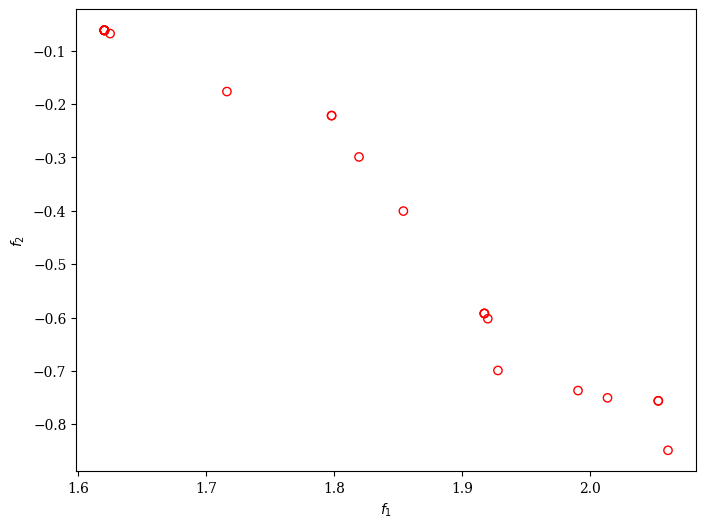

In [60]:
problem = StratClass(df)

algorithm = AGEMOEA(pop_size=100)


res = minimize(problem,
               algorithm,
               ('n_gen', 10),
               seed=1,
               verbose=False)

plot = Scatter()
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res.F, facecolor="none", edgecolor="red")
plot.show()

In [61]:

from deap import base, creator, tools
import random

In [93]:
#Constants
START_BALANCE = 100
FEE = 0.02

# Set up the genetic algorithm
population_size = 100
generations = 15
crossover_probability = 0.8
mutation_probability = 0.2

net_profits = []
std_devs = []

def strategy(df, length = 20,mult = 2,length_KC = 20, mult_KC = 1.5, stop_loss_pct = 0.03, take_profit_pct=0.06):
    length = int(length)
    length_KC = int(length_KC)

    #Calculate percent change
    df['change'] = df['close'].pct_change(1)

    # calculate BB
    m_avg = trend.sma_indicator(df['close'],window=length)
    #m_avg = df['close'].rolling(window=length).mean()
    m_std = df['close'].rolling(window=length).std(ddof=0)
    df['upper_BB'] = m_avg + mult * m_std
    df['lower_BB'] = m_avg - mult * m_std

    # calculate true range
    df['tr0'] = abs(df["high"] - df["low"])
    df['tr1'] = abs(df["high"] - df["close"].shift())
    df['tr2'] = abs(df["low"] - df["close"].shift())
    df['tr'] = df[['tr0', 'tr1', 'tr2']].max(axis=1)

    # calculate Keltner Channels
    range_ma = df['tr'].rolling(window=length_KC).mean()
    df['upper_KC'] = m_avg + range_ma * mult_KC
    df['lower_KC'] = m_avg - range_ma * mult_KC

    # calculate bar value
    highest = df['high'].rolling(window = length_KC).max()
    lowest = df['low'].rolling(window = length_KC).min()
    m1 = (highest + lowest)/2
    df['value'] = (df['close'] - (m1 + m_avg)/2)
    fit_y = np.array(range(0,length_KC))
    df['value'] = df['value'].rolling(window = length_KC).apply(lambda x: 
                              np.polyfit(fit_y, x, 1)[0] * (length_KC-1) + 
                              np.polyfit(fit_y, x, 1)[1], raw=True)

    # check for 'squeeze'
    df['squeeze_on'] = (df['lower_BB'] > df['lower_KC']) & (df['upper_BB'] < df['upper_KC'])
    df['squeeze_off'] = (df['lower_BB'] < df['lower_KC']) & (df['upper_BB'] > df['upper_KC'])

    # buying window for long position:
    # 1. black cross becomes gray (the squeeze is released)
    long_cond1 = (df['squeeze_off'].shift(2)  == False) & (df['squeeze_off'].shift(1)  == True) 
    # 2. bar value is positive => the bar is light green k
    long_cond2 = df['value'].shift(1)  > 0
    df['enter_long'] = long_cond1 & long_cond2

    # buying window for short position:
    # 1. black cross becomes gray (the squeeze is released)
    short_cond1 = (df['squeeze_off'].shift(2) == False) & (df['squeeze_off'].shift(1)  == True) 
    # 2. bar value is negative => the bar is light red 
    short_cond2 = df['value'].shift(1)  < 0
    df['enter_short'] = short_cond1 & short_cond2

    # Calculate stop-loss and take-profit prices for long positions
    in_long_position = False
    in_short_position = False
    cumulative_return = 1.0
    current_trade_return = 1.0
    all_trades = []

    for i in range(1, len(df)):
        # Long trades
        if df['enter_long'][i] == True and not in_short_position:
            in_long_position = True
            cumulative_return *= (1 - FEE)
            current_trade_return = 1.0
        elif in_long_position:
            current_trade_return *= (1 + df['change'][i])
            if (current_trade_return >= (1+take_profit_pct) or current_trade_return <= (1-stop_loss_pct)):
                in_long_position = False
                cumulative_return *= current_trade_return
                #print(f'Long return: {current_trade_return - 1}, current total: {cumulative_return}')
                all_trades.append(current_trade_return)
                current_trade_return = 1.0

        # Short trades
        if df['enter_short'][i] == True and not in_long_position:
            in_short_position = True
            cumulative_return *= (1 - FEE)
            current_trade_return = 1.0
        elif in_short_position:
            current_trade_return *= (1 - df['change'][i])
            if (current_trade_return >= (1+take_profit_pct) or current_trade_return <= (1-stop_loss_pct)):
                in_short_position = False
                cumulative_return *= current_trade_return
                #print(f'Short return: {current_trade_return - 1}, current total: {cumulative_return}')
                all_trades.append(current_trade_return-1)
                current_trade_return = 1.0
    total_risk = np.std(all_trades)
    #print(f"Total Return: {round(START_BALANCE*(cumulative_return),2)}'\n'Net Profit: {round((cumulative_return-1)*100,2)}%'\n'Risk: {round(np.std(all_trades)*100,2)}%")
    return (cumulative_return-1), 1/total_risk

ret, strisk = strategy(df)

# Define the fitness function
def fitness_function(hyperparameters):
    # Unpack the hyperparameters
    length, mult, length_KC, mult_KC, stop_loss_pct, take_profit_pct  = hyperparameters

    # Insert the trading algorithm here and replace the current hyperparameters with the unpacked ones
    # Calculate the return and risk
    
    net_profit, std_dev = strategy(length,mult,length_KC, mult_KC, stop_loss_pct, take_profit_pct)

    # Calculate sharpe ratio
    sharpe_ratio = np.mean(net_profit)/np.mean(std_dev)

    # You can use the average net return, Sharpe ratio, or any other performance metric as the fitness
    fitness = sharpe_ratio

    return fitness,

# Create types
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Initialize the required components for the genetic algorithm
toolbox = base.Toolbox()
toolbox.register("attr_length", random.randint, 5, 40)
toolbox.register("attr_mult", random.uniform, 1.25, 3.5)
toolbox.register("attr_length_KC", random.randint, 5, 40)
toolbox.register("attr_mult_KC", random.uniform, 1.25, 3.5)
toolbox.register("attr_stop_loss_pct", random.uniform, 0.01, 0.1)
toolbox.register("attr_take_profit_pct", random.uniform, 0.01, 0.1)

toolbox.register("individual", tools.initCycle, creator.Individual, 
                 (toolbox.attr_length,toolbox.attr_mult, toolbox.attr_length_KC,
                  toolbox.attr_mult_KC,toolbox.attr_stop_loss_pct, toolbox.attr_take_profit_pct), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxUniform, indpb=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.1)
toolbox.register("select", tools.selBest)
toolbox.register("evaluate", fitness_function)

# Create the initial population
population = toolbox.population(n=population_size)

# Evaluate the fitness of each individual in the population
fitnesses = list(map(toolbox.evaluate, population))
for ind, fit in zip(population, fitnesses):
    ind.fitness.values = fit

# Begin the evolution
for gen in range(generations):
    print('Generation: ', gen)
    # Select the next generation
    offspring = toolbox.select(population, len(population))
    offspring = list(offspring)

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < crossover_probability:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < mutation_probability:
                toolbox.mutate(mutant)
                del mutant.fitness.values

    # Evaluate the fitness of each individual in the new generation
    fitnesses = list(map(toolbox.evaluate, offspring))
    for ind, fit in zip(offspring, fitnesses):
        ind.fitness.values = fit

    # Replace the old population by the offspring
    population[:] = offspring

# Get the best individual from the final population
best_ind = tools.selBest(population, 1)[0] 
print("Best individual is %s with fitness: %s" % (best_ind, best_ind.fitness.values))

C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\cwalt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


TypeError: 'int' object is not subscriptable